In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load|

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/japan-daily-historical-stock-market-1999-2024/Japan Stock Market 1999-2024.csv


In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import accuracy_score
import tensorflow.keras.backend as K
import datetime

In [3]:
# Check if GPU is available and set it as device
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU Available: ", physical_devices)
    # Set TensorFlow to use GPU
    tf.config.set_visible_devices(physical_devices[0], 'GPU')
else:
    print("No GPU available, using CPU instead")

GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [4]:
df = pd.read_csv('/kaggle/input/japan-daily-historical-stock-market-1999-2024/Japan Stock Market 1999-2024.csv')

# Convert date and sort
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

In [5]:
# for i in df['Company_Name'].unique():
#     print(i)
print(df[df['Company_Name'] == 'HITACHI'])
print(df)

         Unnamed: 0       Date  Ticker Company_Name     Open     High  \
9183225     9183225 2000-01-04  6501.T      HITACHI   8300.0   8545.0   
9183226     9183226 2000-01-05  6501.T      HITACHI   7700.0   8000.0   
9183227     9183227 2000-01-06  6501.T      HITACHI   7900.0   7950.0   
9183228     9183228 2000-01-07  6501.T      HITACHI   7300.0   7420.0   
9183229     9183229 2000-01-10  6501.T      HITACHI   7320.0   7320.0   
...             ...        ...     ...          ...      ...      ...   
9189317     9189317 2024-05-17  6501.T      HITACHI  14355.0  14495.0   
9189318     9189318 2024-05-20  6501.T      HITACHI  14440.0  14695.0   
9189319     9189319 2024-05-21  6501.T      HITACHI  14700.0  14975.0   
9189320     9189320 2024-05-22  6501.T      HITACHI  15000.0  15095.0   
9189321     9189321 2024-05-23  6501.T      HITACHI  14960.0  15160.0   

             Low    Close     Adj Close     Volume  
9183225   8230.0   8450.0   5967.150879  2260800.0  
9183226   7560.0 

In [6]:
# Define technical indicator functions
def calculate_sma(data, window):
    return data.rolling(window=window).mean()

def calculate_ema(data, window):
    return data.ewm(span=window, adjust=False).mean()

def calculate_rsi(data, window=14):
    delta = data.diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

def calculate_macd(data, fast_period=12, slow_period=26, signal_period=9):
    ema_fast = calculate_ema(data, fast_period)
    ema_slow = calculate_ema(data, slow_period)
    macd_line = ema_fast - ema_slow
    signal_line = calculate_ema(macd_line, signal_period)
    return macd_line, signal_line

def calculate_bollinger_bands(data, window=20, num_std=2):
    sma = calculate_sma(data, window)
    std = data.rolling(window=window).std()
    upper_band = sma + (std * num_std)
    lower_band = sma - (std * num_std)
    return upper_band, lower_band

def calculate_atr(high, low, close, window=14):
    tr1 = high - low
    tr2 = abs(high - close.shift(1))
    tr3 = abs(low - close.shift(1))
    tr = pd.DataFrame({'tr1': tr1, 'tr2': tr2, 'tr3': tr3}).max(axis=1)
    atr = tr.rolling(window=window).mean()
    return atr

def calculate_obv(close, volume):
    obv = np.zeros(len(close))
    for i in range(1, len(close)):
        if close[i] > close[i-1]:
            obv[i] = obv[i-1] + volume[i]
        elif close[i] < close[i-1]:
            obv[i] = obv[i-1] - volume[i]
        else:
            obv[i] = obv[i-1]
    return pd.Series(obv, index=close.index)

def calculate_vwap(high, low, close, volume):
    typical_price = (high + low + close) / 3
    vwap = (typical_price * volume).cumsum() / volume.cumsum()
    return vwap

def calculate_adx(high, low, close, window=14):
    # Simplified ADX calculation
    plus_dm = high.diff()
    minus_dm = low.diff(-1).abs()
    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm < 0] = 0
    
    tr = pd.DataFrame({
        'tr1': high - low,
        'tr2': (high - close.shift(1)).abs(),
        'tr3': (low - close.shift(1)).abs()
    }).max(axis=1)
    
    atr = tr.rolling(window=window).mean()
    
    plus_di = 100 * (plus_dm.rolling(window=window).mean() / atr)
    minus_di = 100 * (minus_dm.rolling(window=window).mean() / atr)
    
    dx = 100 * ((plus_di - minus_di).abs() / (plus_di + minus_di))
    adx = dx.rolling(window=window).mean()
    
    return adx

In [7]:
def preprocess_data(df, stock_name):
    # Select relevant data for the stock
    stock_data = df[df['Company_Name'] == stock_name].reset_index(drop=True)
    
    # Sort by date
    stock_data['Date'] = pd.to_datetime(stock_data['Date'])
    stock_data = stock_data.sort_values('Date')
    
    # Handle missing values
    stock_data = stock_data.fillna(method='ffill').fillna(method='bfill')
    
    # Feature Engineering - Technical Indicators
    stock_data['SMA_5'] = calculate_sma(stock_data['Close'], 5)
    stock_data['SMA_10'] = calculate_sma(stock_data['Close'], 10)
    stock_data['SMA_20'] = calculate_sma(stock_data['Close'], 20)
    stock_data['EMA_5'] = calculate_ema(stock_data['Close'], 5)
    stock_data['EMA_10'] = calculate_ema(stock_data['Close'], 10)
    stock_data['EMA_20'] = calculate_ema(stock_data['Close'], 20)
    
    # Momentum Indicators
    stock_data['RSI'] = calculate_rsi(stock_data['Close'], window=14)
    stock_data['MACD'], stock_data['MACD_signal'] = calculate_macd(stock_data['Close'])
    
    # Volatility Indicators
    stock_data['Upper_BB'], stock_data['Lower_BB'] = calculate_bollinger_bands(stock_data['Close'])
    stock_data['ATR'] = calculate_atr(stock_data['High'], stock_data['Low'], stock_data['Close'], window=14)
    
    # Volume-based Indicators
    stock_data['OBV'] = calculate_obv(stock_data['Close'], stock_data['Volume'])
    stock_data['VWAP'] = calculate_vwap(stock_data['High'], stock_data['Low'], stock_data['Close'], stock_data['Volume'])
    
    # Price-based features
    stock_data['Daily_Return'] = stock_data['Close'].pct_change()
    stock_data['Log_Return'] = np.log(stock_data['Close'] / stock_data['Close'].shift(1))
    stock_data['Volatility'] = stock_data['Daily_Return'].rolling(window=10).std()
    stock_data['Price_Range'] = (stock_data['High'] - stock_data['Low']) / stock_data['Close']
    
    # Trend Indicators
    stock_data['ADX'] = calculate_adx(stock_data['High'], stock_data['Low'], stock_data['Close'], window=14)
    
    # Fill NaN values
    stock_data = stock_data.fillna(method='ffill').fillna(method='bfill')
    
    return stock_data

In [8]:
def prepare_data(data, look_back=60):
    features = ['Close', 'SMA_5', 'EMA_5','SMA_20', 'EMA_20', 'RSI', 'MACD', 'MACD_signal', 
               'Upper_BB', 'Lower_BB', 'Daily_Return', 'Volatility', 'Price_Range',
               'ATR', 'OBV', 'ADX','VWAP']
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data[features])
    
    
    X, y = [], []
    for i in range(look_back, len(scaled_data)):
        X.append(scaled_data[i-look_back:i])
        y.append(scaled_data[i, 0]) # Close price is the target
    
    return np.array(X), np.array(y), scaler, features

In [9]:
def directional_asymmetric_loss(y_true, y_pred, alpha=2.0):
    # Shift y_true and y_pred by one position (prepend 0)
    y_true_shifted = tf.concat([y_true[:1], y_true[:-1]], axis=0)
    y_pred_shifted = tf.concat([y_pred[:1], y_pred[:-1]], axis=0)
    
    # Calculate the direction of movement
    true_direction = tf.sign(y_true - y_true_shifted)
    pred_direction = tf.sign(y_pred - y_pred_shifted)
    
    # Calculate the base MSE loss
    mse_loss = tf.square(y_true - y_pred)
    
    # Apply asymmetric penalty for wrong direction
    direction_match = tf.cast(tf.equal(true_direction, pred_direction), tf.float32)
    direction_penalty = tf.where(direction_match > 0, 1.0, alpha)
    
    # Final loss is MSE with directional penalty
    final_loss = mse_loss * direction_penalty
    
    return tf.reduce_mean(final_loss)

In [10]:
def create_enhanced_lstm_model(input_shape, dropout_rate=0.3):
    model = Sequential([
        # First LSTM layer with return sequences
        LSTM(128, return_sequences=True, input_shape=input_shape, 
             recurrent_dropout=0.2, activation='tanh'),
        BatchNormalization(),
        Dropout(dropout_rate),
        
        # Second LSTM layer with return sequences
        LSTM(64, return_sequences=True, recurrent_dropout=0.2, activation='tanh'),
        BatchNormalization(),
        Dropout(dropout_rate),
        
        # Third LSTM layer without return sequences
        LSTM(32, recurrent_dropout=0.2, activation='tanh'),
        BatchNormalization(),
        Dropout(dropout_rate),
        
        # Dense layers for better feature extraction
        Dense(16, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate/2),
        
        # Output layer
        Dense(1)
    ])
    
    return model

In [11]:
def inverse_transform_predictions(y_pred, y_actual, scaler, features):
    # Create dummy arrays for the features we're not predicting
    dummy_array_pred = np.zeros((len(y_pred), len(features)))
    dummy_array_pred[:, 0] = y_pred.flatten() # Set the first column (Close price)
    
    dummy_array_actual = np.zeros((len(y_actual), len(features)))
    dummy_array_actual[:, 0] = y_actual # Set the first column (Close price)
    
    # Inverse transform
    y_pred_inv = scaler.inverse_transform(dummy_array_pred)[:, 0]
    y_actual_inv = scaler.inverse_transform(dummy_array_actual)[:, 0]
    
    return y_pred_inv, y_actual_inv

def directional_accuracy(y_true, y_pred):
    """Calculate the percentage of correct directional predictions"""
    true_direction = np.sign(y_true[1:] - y_true[:-1])
    pred_direction = np.sign(y_pred[1:] - y_pred[:-1])
    
    # Count matches and calculate percentage
    matches = np.sum(true_direction == pred_direction)
    return (matches / len(true_direction)) * 100

def mean_absolute_percentage_error(y_true, y_pred):
    """Calculate MAPE"""
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [12]:
def plot_training_validation_loss(history, stock_name):
    """Plot training and validation loss over epochs."""
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title(f'{stock_name} - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{stock_name}_loss_curve.png')
    plt.show()

def calculate_direction(y_true, y_pred):
    """Convert price predictions to directional predictions (1 for up, 0 for down)"""
    true_direction = np.sign(y_true[1:] - y_true[:-1])
    pred_direction = np.sign(y_pred[1:] - y_pred[:-1])
    
    # Convert to binary (1 for up, 0 for down/flat)
    true_binary = (true_direction > 0).astype(int)
    pred_binary = (pred_direction > 0).astype(int)
    
    return true_binary, pred_binary

def plot_confusion_matrix(y_true, y_pred, stock_name):
    """Plot confusion matrix for directional predictions."""
    # Convert to directional predictions
    true_binary, pred_binary = calculate_direction(y_true, y_pred)
    
    # Create confusion matrix
    cm = confusion_matrix(true_binary, pred_binary)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Down', 'Up'])
    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.title(f'{stock_name} - Direction Prediction Confusion Matrix')
    plt.savefig(f'{stock_name}_confusion_matrix.png')
    plt.show()
    
    return true_binary, pred_binary

In [13]:
def calculate_metrics(y_true, y_pred):
    """Calculate accuracy, precision, recall, and F1 score for directional predictions."""
    # Convert to directional predictions
    true_binary, pred_binary = calculate_direction(y_true, y_pred)
    
    accuracy = accuracy_score(true_binary, pred_binary)
    precision = precision_score(true_binary, pred_binary, zero_division=0)
    recall = recall_score(true_binary, pred_binary, zero_division=0)
    f1 = f1_score(true_binary, pred_binary, zero_division=0)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

In [14]:
def predict_next_n_days(model, stock_data, scaler, features, look_back=60, n_days=30, prediction_horizon='daily'):
    """
    Predict stock prices for the next n days
    """
    # Get the last sequence of data
    last_sequence = stock_data[features].tail(look_back).values
    
    # Scale the data
    last_sequence_scaled = scaler.transform(last_sequence)
    
    # Reshape for LSTM input
    X_pred = np.array([last_sequence_scaled])
    
    # Initialize predictions array
    predictions = []
    dates = []
    
    # Get the last date in the dataset
    last_date = stock_data['Date'].iloc[-1]
    
    # Generate future dates based on prediction horizon
    if prediction_horizon == 'daily':
        date_increment = pd.Timedelta(days=1)
    elif prediction_horizon == 'weekly':
        date_increment = pd.Timedelta(weeks=1)
    else:  # monthly
        date_increment = pd.Timedelta(days=30)
    
    # Make predictions for n days
    for i in range(n_days):
        # Predict the next day
        next_pred = model.predict(X_pred)
        
        # Create a dummy array for inverse transformation
        dummy_array = np.zeros((1, len(features)))
        dummy_array[0, 0] = next_pred[0, 0]  # Set the Close price
        
        # Inverse transform to get the actual price
        next_pred_inv = scaler.inverse_transform(dummy_array)[0, 0]
        predictions.append(next_pred_inv)
        
        # Calculate the next date
        next_date = last_date + date_increment * (i + 1)
        dates.append(next_date)
        
        # Update the sequence for the next prediction
        X_pred = np.roll(X_pred, -1, axis=1)
        X_pred[0, -1] = next_pred[0, 0]
    
    return pd.DataFrame({'Date': dates, 'Predicted_Close': predictions})

In [ ]:
def visualize_predictions(results, horizon):
    """Visualize predictions for each stock with enhanced metrics"""
    for stock_name, result in results.items():
        # Plot price predictions
        plt.figure(figsize=(16, 8))
        plt.plot(result['test']['actual'], label='Actual Price', color='blue')
        plt.plot(result['test']['predicted'], label='Predicted Price', color='red', linestyle='--')
        plt.title(f'{stock_name} - {horizon.capitalize()} Stock Price Prediction')
        plt.xlabel('Time(Day)')
        plt.ylabel('Price (JPY)')
        plt.legend()
        plt.grid(True)
        plt.savefig(f'{stock_name}_{horizon}_prediction.png')
        plt.show()
        
        # Plot training and validation loss
        plot_training_validation_loss(result['history'], stock_name)
        
        # Plot confusion matrix for directional predictions
        true_binary, pred_binary = plot_confusion_matrix(
            result['test']['actual'], 
            result['test']['predicted'], 
            stock_name
        )
        
        # Calculate and display metrics
        metrics = calculate_metrics(result['test']['actual'], result['test']['predicted'])
        print(f"\nPerformance Metrics for {stock_name} Direction Prediction:")
        print(f"Accuracy: {metrics['accuracy']:.4f}")
        print(f"Precision: {metrics['precision']:.4f}")
        print(f"Recall: {metrics['recall']:.4f}")
        print(f"F1 Score: {metrics['f1_score']:.4f}")
        
        # Plot future predictions
        # if 'future_predictions' in result:
        #     plt.figure(figsize=(14, 7))
        #     # Plot the last 30 actual prices for context
        #     last_actual = result['test']['actual'][-30:]
        #     plt.plot(range(len(last_actual)), last_actual, label='Historical Price', color='blue')
            
        #     # Plot future predictions
        #     future_dates = range(len(last_actual), len(last_actual) + len(result['future_predictions']))
        #     plt.plot(future_dates, result['future_predictions']['Predicted_Close'], 
        #             label='Future Predictions', color='green', linestyle='--')
            
        #     plt.title(f'{stock_name} - Future Price Predictions (Next 30 Days)')
        #     plt.xlabel('Days')
        #     plt.ylabel('Price (JPY)')
        #     plt.legend()
        #     plt.grid(True)
        #     plt.savefig(f'{stock_name}_{horizon}_future_prediction.png')
        #     plt.show()
            
            # Display future predictions table
        print(f"\nFuture Price Predictions for {stock_name}:")
        print(result['future_predictions'].to_string(index=False))

In [16]:
def predict_multiple_stocks(df, stock_names, look_back=60, prediction_horizon='daily'):
    results = {}
    
    for stock_name in stock_names:
        print(f"\nProcessing {stock_name}...")
        
        # Preprocess data for this stock
        stock_data = preprocess_data(df, stock_name)
        
        # For weekly prediction, resample to weekly data
        if prediction_horizon == 'weekly':
            stock_data = stock_data.resample('W', on='Date').last()
        # For monthly prediction, resample to monthly data
        elif prediction_horizon == 'monthly':
            stock_data = stock_data.resample('M', on='Date').last()
        
        # Prepare features and target
        X, y, scaler, features = prepare_data(stock_data, look_back)
        
        # Split data
        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
        
        # Create and compile model
        model = create_enhanced_lstm_model((X_train.shape[1], X_train.shape[2]))
        model.compile(optimizer=Adam(learning_rate=0.001), loss=directional_asymmetric_loss)
        
        # Train model
        early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
        model_checkpoint = ModelCheckpoint(f'best_model_{stock_name}.keras', save_best_only=True, monitor='val_loss')
        
        history = model.fit(
            X_train, y_train,
            epochs=100,
            batch_size=32,
            validation_data=(X_val, y_val),
            callbacks=[early_stopping, model_checkpoint],
            verbose=1
        )
        
        # Make predictions
        y_val_pred = model.predict(X_val)
        y_test_pred = model.predict(X_test)
        
        # Inverse transform predictions and actual values
        y_val_pred_inv, y_val_inv = inverse_transform_predictions(y_val_pred, y_val, scaler, features)
        y_test_pred_inv, y_test_inv = inverse_transform_predictions(y_test_pred, y_test, scaler, features)
        
        # Calculate metrics
        val_mse = mean_squared_error(y_val_inv, y_val_pred_inv)
        val_rmse = np.sqrt(val_mse)
        val_r2 = r2_score(y_val_inv, y_val_pred_inv)
        val_mape = mean_absolute_percentage_error(y_val_inv, y_val_pred_inv)
        
        test_mse = mean_squared_error(y_test_inv, y_test_pred_inv)
        test_rmse = np.sqrt(test_mse)
        test_r2 = r2_score(y_test_inv, y_test_pred_inv)
        test_mape = mean_absolute_percentage_error(y_test_inv, y_test_pred_inv)
        
        # Calculate directional accuracy
        val_direction_accuracy = directional_accuracy(y_val_inv, y_val_pred_inv)
        test_direction_accuracy = directional_accuracy(y_test_inv, y_test_pred_inv)
        
        # Predict next 30 days
        future_predictions = predict_next_n_days(model, stock_data, scaler, features, look_back, n_days=30, prediction_horizon=prediction_horizon)
        
        # Store results
        results[stock_name] = {
            'validation': {
                'mse': val_mse,
                'rmse': val_rmse,
                'r2': val_r2,
                'mape': val_mape,
                'direction_accuracy': val_direction_accuracy,
                'actual': y_val_inv,
                'predicted': y_val_pred_inv
            },
            'test': {
                'mse': test_mse,
                'rmse': test_rmse,
                'r2': test_r2,
                'mape': test_mape,
                'direction_accuracy': test_direction_accuracy,
                'actual': y_test_inv,
                'predicted': y_test_pred_inv
            },
            'model': model,
            'history': history,
            'future_predictions': future_predictions
        }
        
        print(f"Completed {stock_name} prediction with test RMSE: {test_rmse:.2f}, Direction Accuracy: {test_direction_accuracy:.2f}%")
    
    return results

In [17]:
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU is available and configured for TensorFlow")
else:
    print("No GPU available, using CPU")

GPU is available and configured for TensorFlow


In [18]:
stock_names = ['TOYOTA MOTOR CORP', 'MITSUBISHI UFJ FINANCIAL GROUP INC']

In [19]:
'KEYENCE CORP','NIPPON TEL & TEL CORP','HITACHI','CHUGAI PHARMACEUTICAL CO','JAPAN TOBACCO INC','SHIN-ETSU CHEMICAL CO','MITSUBISHI HEAVY INDUSTRIES','TOKYO ELEC POWER CO HLDGS INC','MITSUI FUDOSAN'

('KEYENCE CORP',
 'NIPPON TEL & TEL CORP',
 'HITACHI',
 'CHUGAI PHARMACEUTICAL CO',
 'JAPAN TOBACCO INC',
 'SHIN-ETSU CHEMICAL CO',
 'MITSUBISHI HEAVY INDUSTRIES',
 'TOKYO ELEC POWER CO HLDGS INC',
 'MITSUI FUDOSAN')


Processing HITACHI...


<ipython-input-10-839109985a8c>:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data = stock_data.fillna(method='ffill').fillna(method='bfill')
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in 

Epoch 1/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 34s 216ms/step - loss: 0.9275 - val_loss: 0.0173
Epoch 2/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 211ms/step - loss: 0.2648 - val_loss: 0.0095
Epoch 3/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 211ms/step - loss: 0.1525 - val_loss: 0.0032
Epoch 4/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 211ms/step - loss: 0.1065 - val_loss: 0.0029
Epoch 5/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 212ms/step - loss: 0.0727 - val_loss: 0.0040
Epoch 6/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 212ms/step - loss: 0.0523 - val_loss: 0.0023
Epoch 7/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 213ms/step - loss: 0.0378 - val_loss: 0.0018
Epoch 8/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 209ms/step - loss: 0.0263 - val_loss: 0.0028
Epoch 9/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 211ms/step - loss: 0.0200 - val_loss: 0.0020
Epoch 10/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 211ms/step - loss: 0.0152 - val_loss: 0.0019
Epoch 11/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 213ms/step - loss: 0.0149 - val_loss: 0.0016
Epoch 12

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━

<ipython-input-10-839109985a8c>:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data = stock_data.fillna(method='ffill').fillna(method='bfill')
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in 

Epoch 1/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 33s 212ms/step - loss: 1.8777 - val_loss: 0.0646
Epoch 2/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 208ms/step - loss: 0.6681 - val_loss: 0.0371
Epoch 3/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 209ms/step - loss: 0.3803 - val_loss: 0.0145
Epoch 4/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 210ms/step - loss: 0.2559 - val_loss: 0.0108
Epoch 5/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 210ms/step - loss: 0.1907 - val_loss: 0.0051
Epoch 6/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 208ms/step - loss: 0.1464 - val_loss: 0.0110
Epoch 7/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 211ms/step - loss: 0.1048 - val_loss: 0.0170
Epoch 8/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 29s 214ms/step - loss: 0.0777 - val_loss: 0.0104
Epoch 9/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 29s 217ms/step - loss: 0.0583 - val_loss: 0.0061
Epoch 10/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 213ms/step - loss: 0.0458 - val_loss: 0.0035
Epoch 11/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 210ms/step - loss: 0.0365 - val_loss: 0.0044
Epoch 12

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━

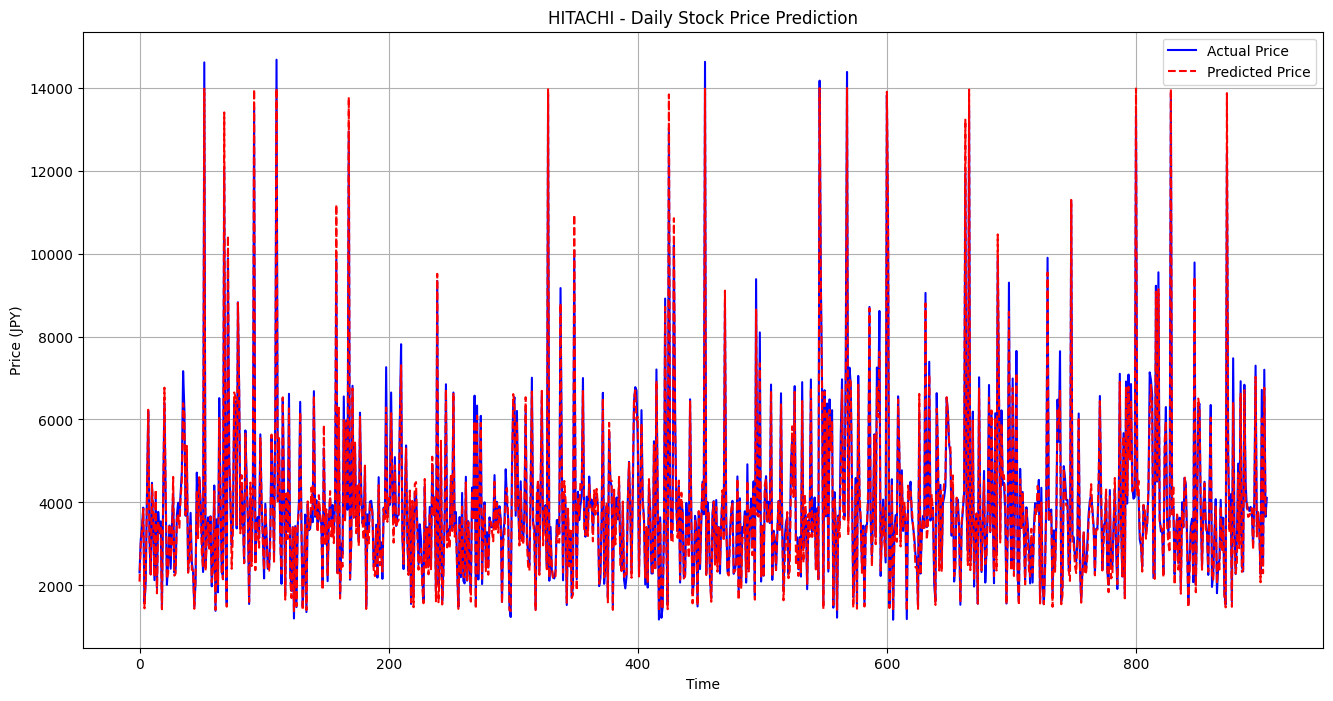

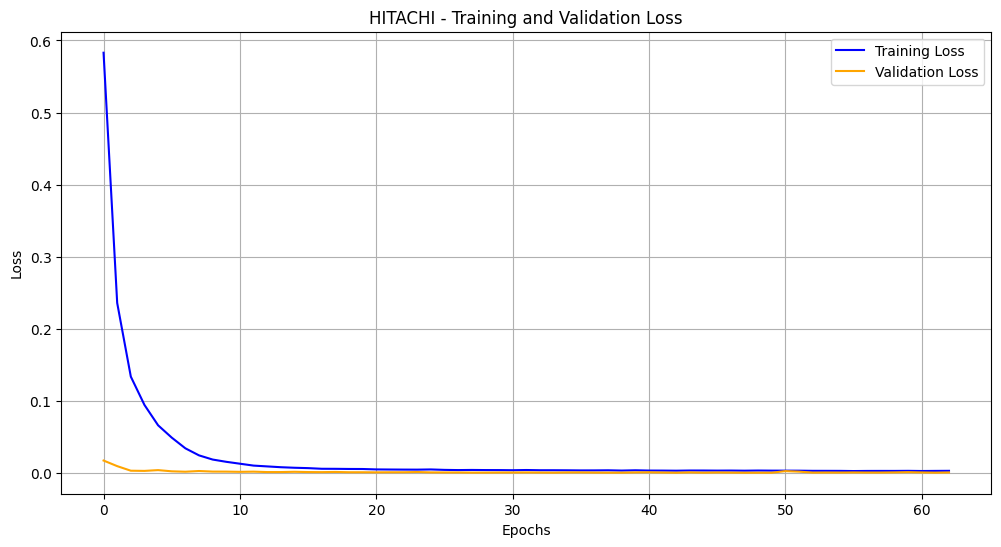

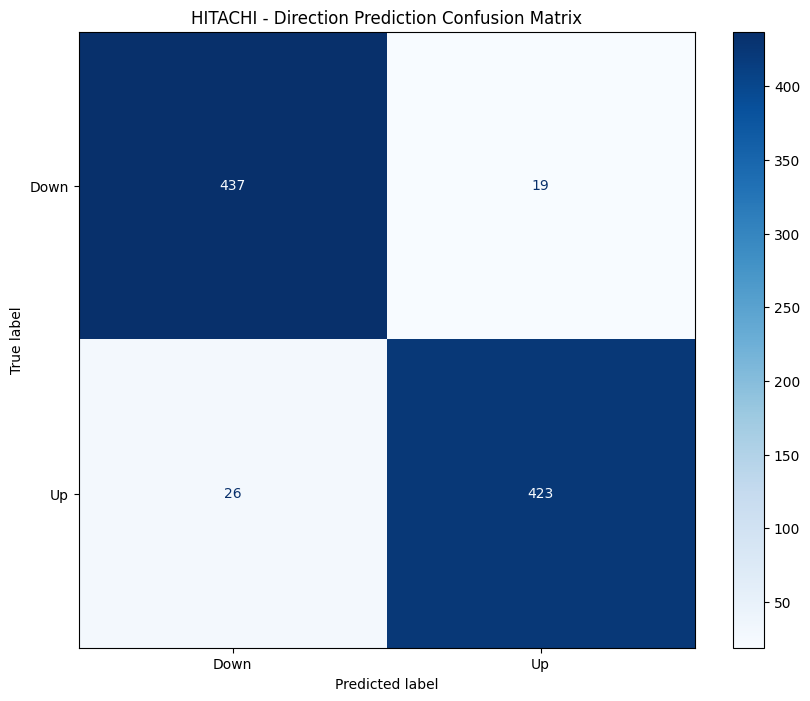


Performance Metrics for HITACHI Direction Prediction:
Accuracy: 0.9503
Precision: 0.9570
Recall: 0.9421
F1 Score: 0.9495

Future Price Predictions for HITACHI:
      Date  Predicted_Close
2024-05-24     13984.068661
2024-05-25     13976.994901
2024-05-26     13969.195991
2024-05-27     13961.024909
2024-05-28     13953.377872
2024-05-29     13946.553617
2024-05-30     13940.722375
2024-05-31     13935.750632
2024-06-01     13931.476502
2024-06-02     13927.557855
2024-06-03     13923.882871
2024-06-04     13920.207887
2024-06-05     13916.168242
2024-06-06     13911.547809
2024-06-07     13906.288176
2024-06-08     13900.330095
2024-06-09     13893.563418
2024-06-10     13885.924726
2024-06-11     13876.917510
2024-06-12     13866.276412
2024-06-13     13853.233724
2024-06-14     13837.914615
2024-06-15     13822.076468
2024-06-16     13807.242184
2024-06-17     13794.070988
2024-06-18     13783.041029
2024-06-19     13773.018270
2024-06-20     13764.022737
2024-06-21     13755.546241

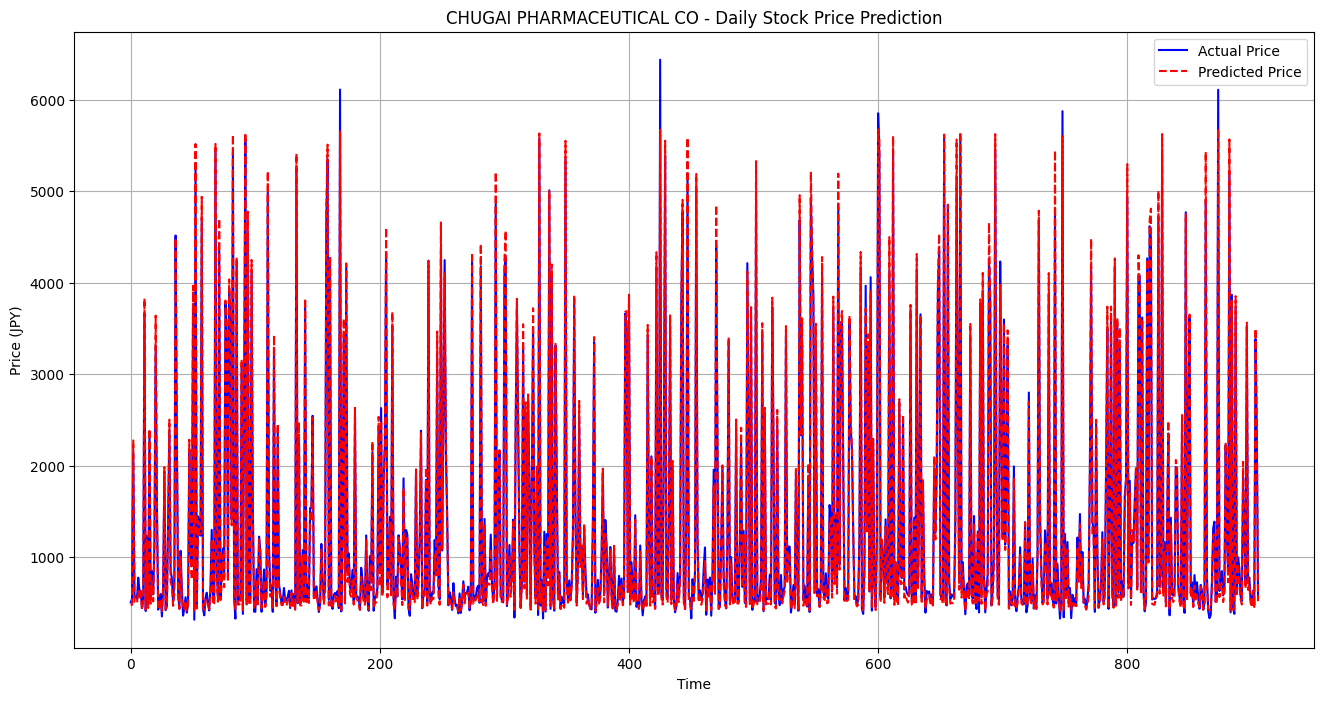

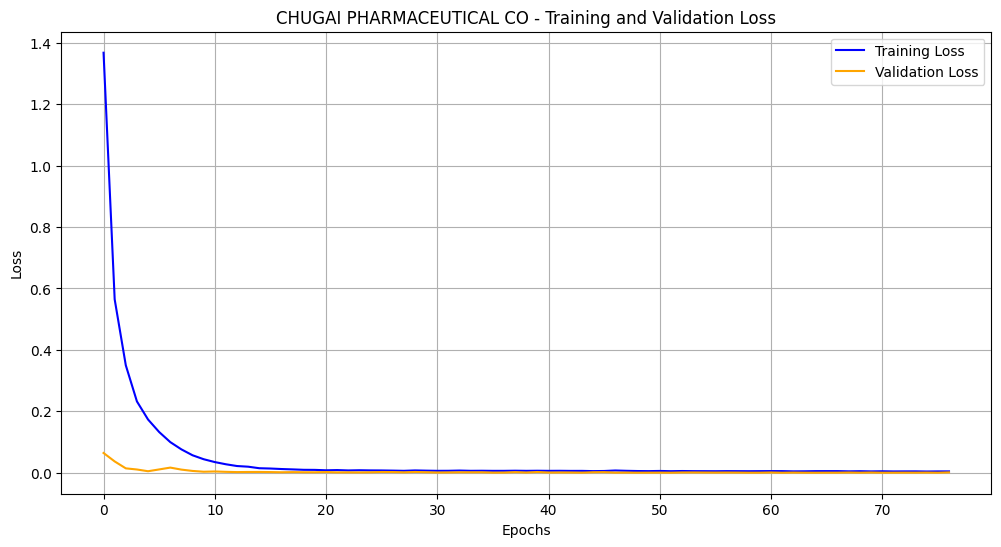

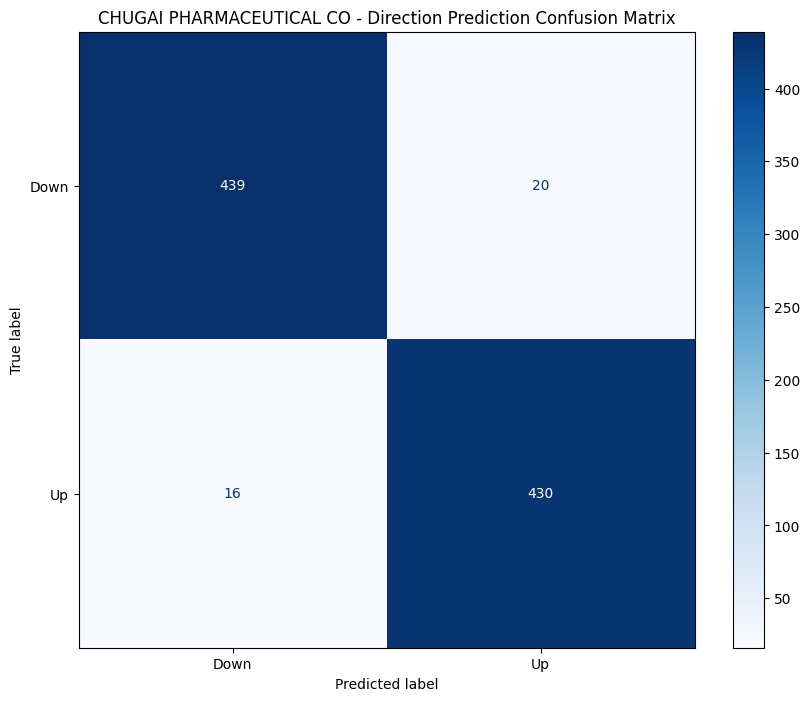


Performance Metrics for CHUGAI PHARMACEUTICAL CO Direction Prediction:
Accuracy: 0.9602
Precision: 0.9556
Recall: 0.9641
F1 Score: 0.9598

Future Price Predictions for CHUGAI PHARMACEUTICAL CO:
      Date  Predicted_Close
2024-05-24      5158.911951
2024-05-25      5269.903450
2024-05-26      5351.414601
2024-05-27      5406.567068
2024-05-28      5444.992072
2024-05-29      5472.924399
2024-05-30      5493.786105
2024-05-31      5509.980357
2024-06-01      5522.657864
2024-06-02      5532.710902
2024-06-03      5540.905870
2024-06-04      5547.674980
2024-06-05      5553.372841
2024-06-06      5558.398617
2024-06-07      5562.620492
2024-06-08      5566.580589
2024-06-09      5569.850036
2024-06-10      5572.754849
2024-06-11      5575.205542
2024-06-12      5577.546324
2024-06-13      5579.704048
2024-06-14      5581.510877
2024-06-15      5583.097143
2024-06-16      5584.603948
2024-06-17      5585.943660
2024-06-18      5587.192028
2024-06-19      5588.371702
2024-06-20      5589.

In [22]:
stock_names = ['HITACHI','CHUGAI PHARMACEUTICAL CO']
results = predict_multiple_stocks(df, stock_names, look_back=60, prediction_horizon='daily')
    
    # Visualize predictions
visualize_predictions(results, 'daily')


Processing JAPAN TOBACCO INC...


<ipython-input-7-839109985a8c>:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data = stock_data.fillna(method='ffill').fillna(method='bfill')
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in l

Epoch 1/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 37s 213ms/step - loss: 1.9750 - val_loss: 0.0192
Epoch 2/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 211ms/step - loss: 0.5255 - val_loss: 0.0220
Epoch 3/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 210ms/step - loss: 0.3036 - val_loss: 0.0129
Epoch 4/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 210ms/step - loss: 0.2366 - val_loss: 0.0137
Epoch 5/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 211ms/step - loss: 0.1602 - val_loss: 0.0178
Epoch 6/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 211ms/step - loss: 0.1301 - val_loss: 0.0050
Epoch 7/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 211ms/step - loss: 0.0856 - val_loss: 0.0033
Epoch 8/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 213ms/step - loss: 0.0701 - val_loss: 0.0038
Epoch 9/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 209ms/step - loss: 0.0587 - val_loss: 0.0052
Epoch 10/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 210ms/step - loss: 0.0447 - val_loss: 0.0034
Epoch 11/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 211ms/step - loss: 0.0338 - val_loss: 0.0024
Epoch 12

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━

<ipython-input-7-839109985a8c>:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data = stock_data.fillna(method='ffill').fillna(method='bfill')
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in l

Epoch 1/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 34s 216ms/step - loss: 1.1650 - val_loss: 0.0445
Epoch 2/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 210ms/step - loss: 0.3115 - val_loss: 0.0074
Epoch 3/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 212ms/step - loss: 0.2181 - val_loss: 0.0069
Epoch 4/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 210ms/step - loss: 0.1347 - val_loss: 0.0086
Epoch 5/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 210ms/step - loss: 0.0958 - val_loss: 0.0024
Epoch 6/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 210ms/step - loss: 0.0728 - val_loss: 0.0035
Epoch 7/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 210ms/step - loss: 0.0493 - val_loss: 0.0040
Epoch 8/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 211ms/step - loss: 0.0358 - val_loss: 0.0041
Epoch 9/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 210ms/step - loss: 0.0292 - val_loss: 0.0029
Epoch 10/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 210ms/step - loss: 0.0217 - val_loss: 0.0031
Epoch 11/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 210ms/step - loss: 0.0163 - val_loss: 0.0030
Epoch 12

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━

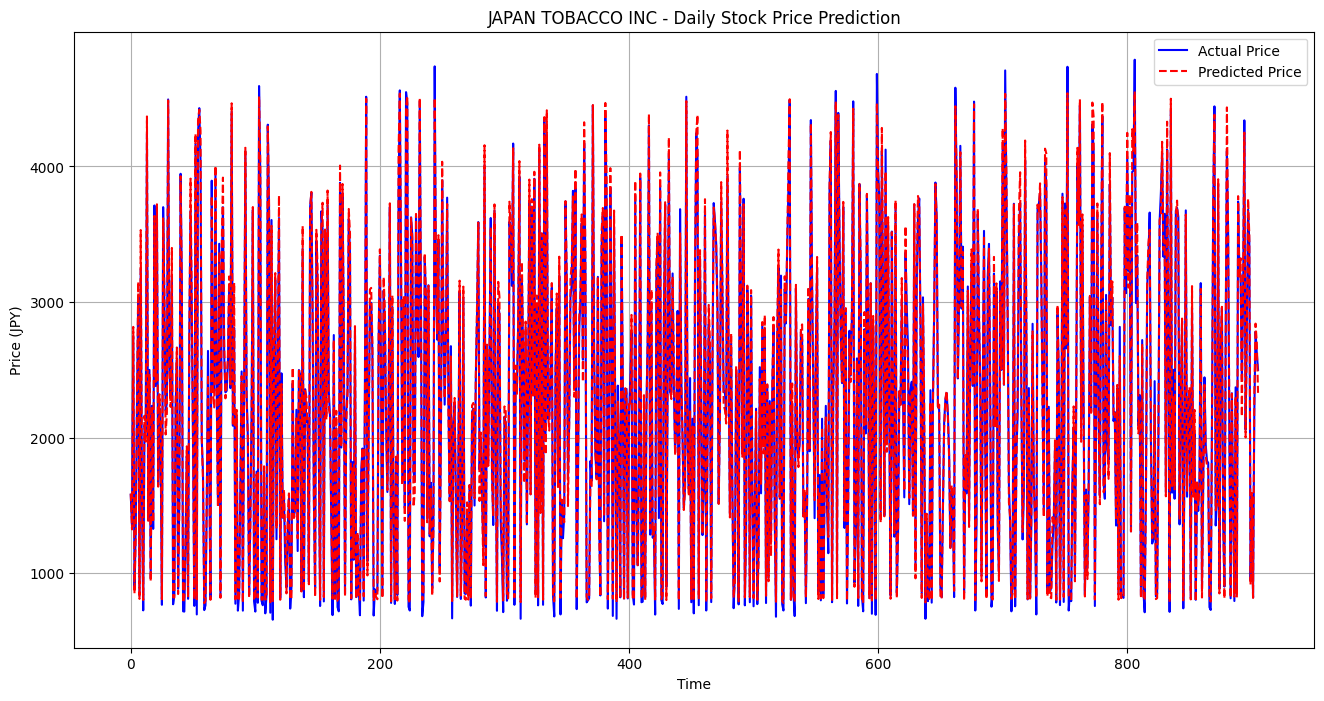

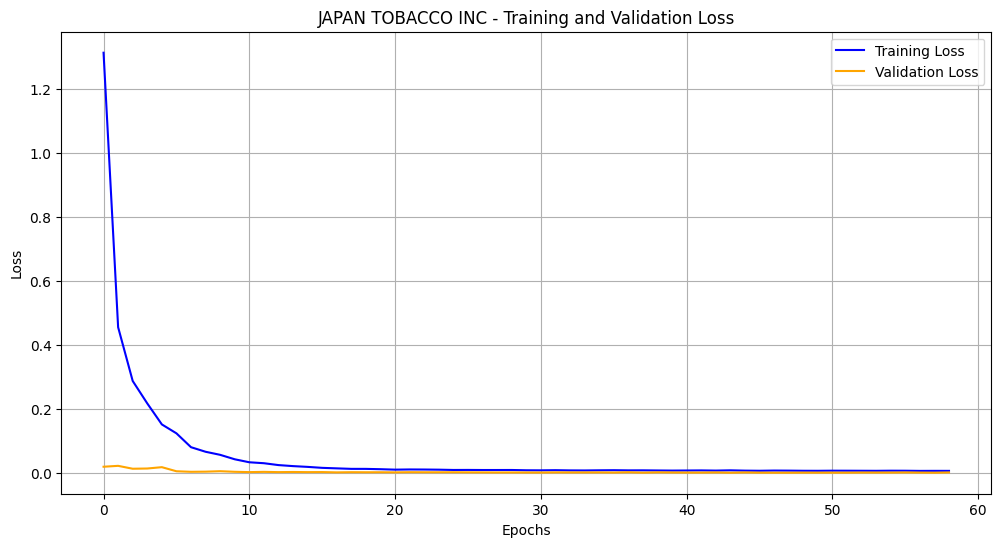

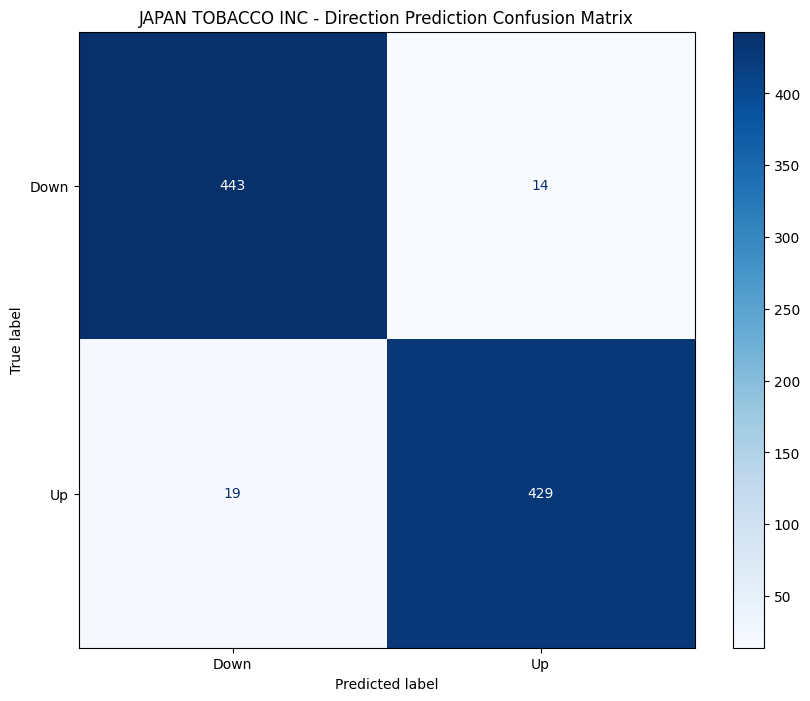


Performance Metrics for JAPAN TOBACCO INC Direction Prediction:
Accuracy: 0.9635
Precision: 0.9684
Recall: 0.9576
F1 Score: 0.9630

Future Price Predictions for JAPAN TOBACCO INC:
      Date  Predicted_Close
2024-05-24      4439.909420
2024-05-25      4449.773931
2024-05-26      4455.115998
2024-05-27      4458.370476
2024-05-28      4461.139584
2024-05-29      4463.701035
2024-05-30      4466.194433
2024-05-31      4468.758886
2024-06-01      4471.635576
2024-06-02      4474.611342
2024-06-03      4477.735220
2024-06-04      4480.874110
2024-06-05      4483.973971
2024-06-06      4487.090844
2024-06-07      4489.977041
2024-06-08      4492.642571
2024-06-09      4494.803716
2024-06-10      4496.607590
2024-06-11      4498.262350
2024-06-12      4499.707951
2024-06-13      4500.963907
2024-06-14      4502.238878
2024-06-15      4503.313196
2024-06-16      4504.143828
2024-06-17      4504.860374
2024-06-18      4505.423803
2024-06-19      4505.861136
2024-06-20      4506.205898
2024-06

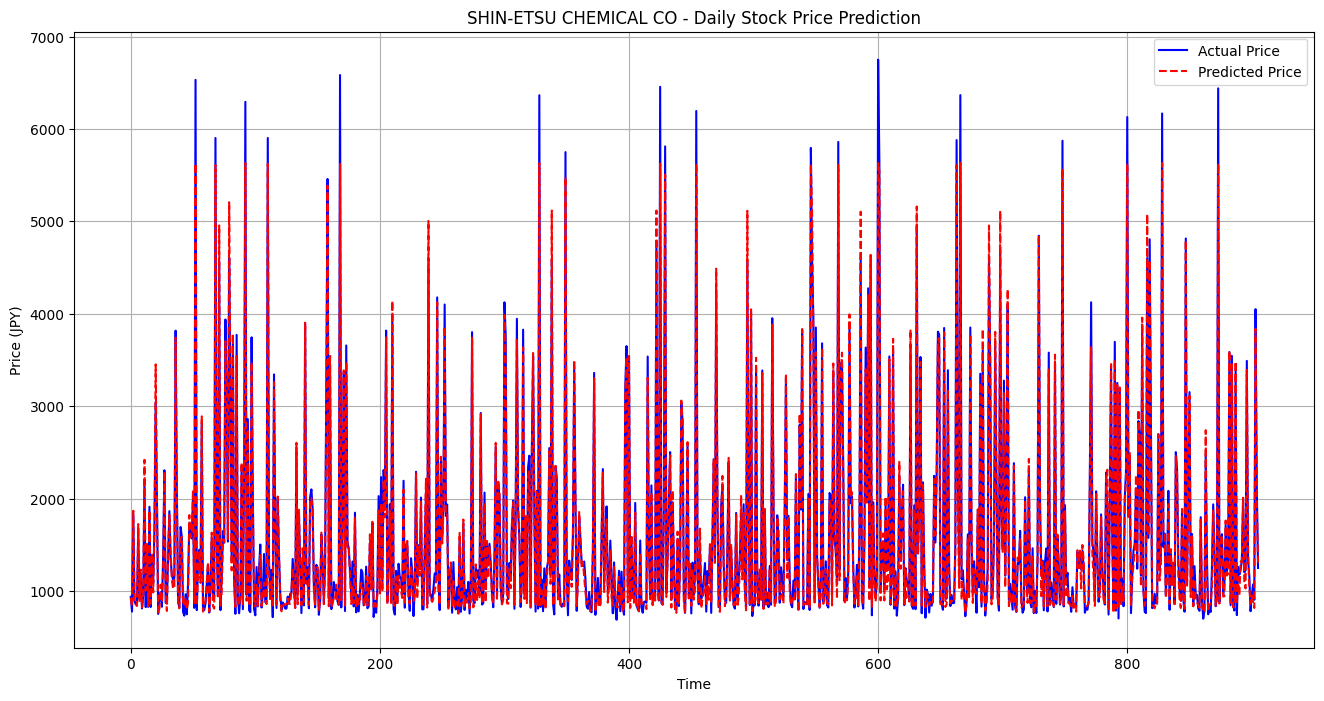

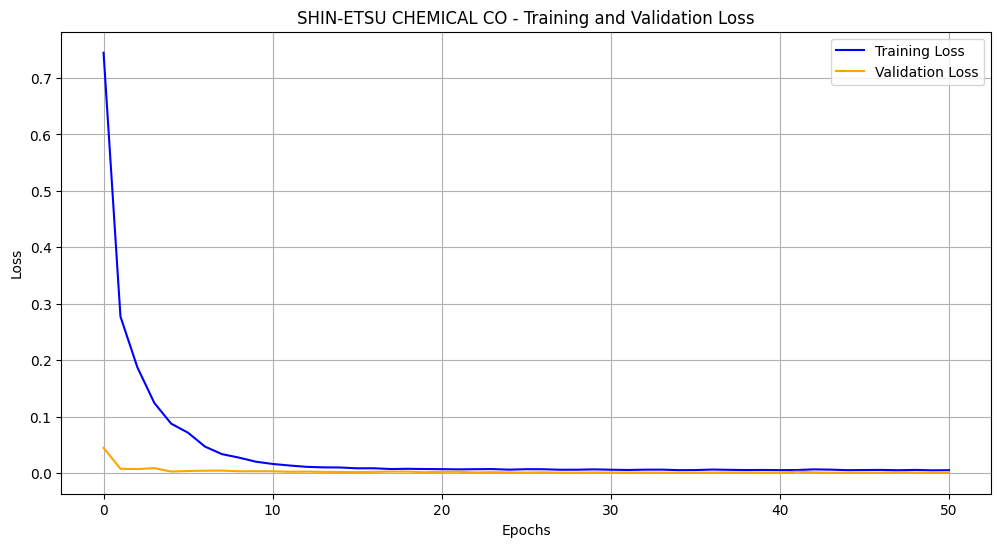

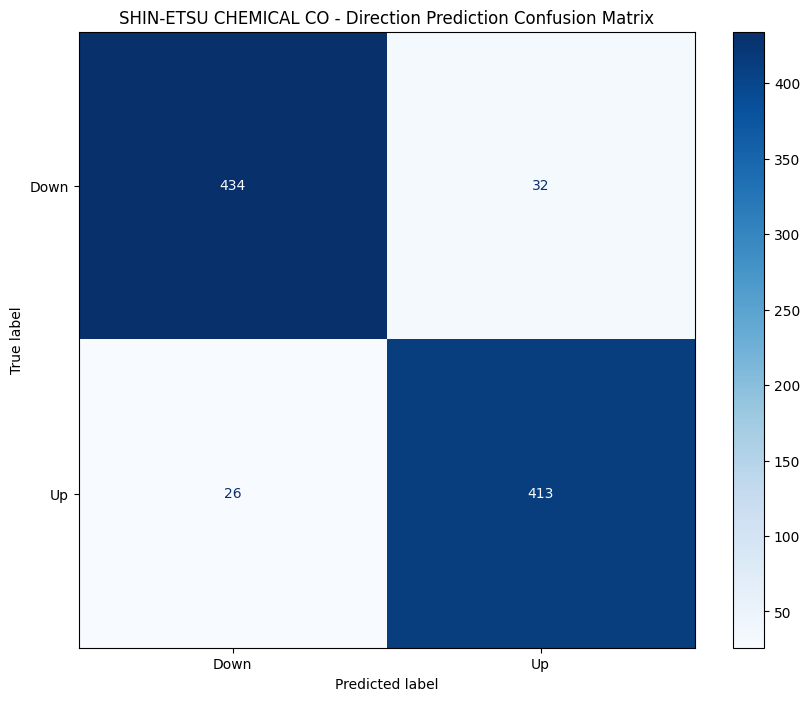


Performance Metrics for SHIN-ETSU CHEMICAL CO Direction Prediction:
Accuracy: 0.9359
Precision: 0.9281
Recall: 0.9408
F1 Score: 0.9344

Future Price Predictions for SHIN-ETSU CHEMICAL CO:
      Date  Predicted_Close
2024-05-24      5594.048397
2024-05-25      5593.272823
2024-05-26      5595.001953
2024-05-27      5596.881313
2024-05-28      5598.716640
2024-05-29      5600.311821
2024-05-30      5601.640583
2024-05-31      5602.727348
2024-06-01      5603.479240
2024-06-02      5603.995056
2024-06-03      5603.998016
2024-06-04      5603.748249
2024-06-05      5603.115135
2024-06-06      5602.226334
2024-06-07      5601.233555
2024-06-08      5600.056503
2024-06-09      5598.777695
2024-06-10      5597.500366
2024-06-11      5596.117950
2024-06-12      5594.696312
2024-06-13      5593.208809
2024-06-14      5591.510761
2024-06-15      5589.806053
2024-06-16      5588.275257
2024-06-17      5586.683407
2024-06-18      5585.468243
2024-06-19      5584.253448
2024-06-20      5583.230328

In [18]:
stock_names = ['JAPAN TOBACCO INC', 'SHIN-ETSU CHEMICAL CO']
results = predict_multiple_stocks(df, stock_names, look_back=60, prediction_horizon='daily')
    
    # Visualize predictions
visualize_predictions(results, 'daily')


Processing TOYOTA MOTOR CORP...


<ipython-input-7-839109985a8c>:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data = stock_data.fillna(method='ffill').fillna(method='bfill')
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in l

Epoch 1/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 38s 213ms/step - loss: 1.9252 - val_loss: 0.0167
Epoch 2/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 28s 207ms/step - loss: 0.5202 - val_loss: 0.0120
Epoch 3/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 28s 208ms/step - loss: 0.3038 - val_loss: 0.0082
Epoch 4/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 29s 211ms/step - loss: 0.2273 - val_loss: 0.0080
Epoch 5/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 28s 208ms/step - loss: 0.1570 - val_loss: 0.0114
Epoch 6/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 28s 209ms/step - loss: 0.1063 - val_loss: 0.0082
Epoch 7/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 29s 211ms/step - loss: 0.0739 - val_loss: 0.0047
Epoch 8/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 28s 209ms/step - loss: 0.0560 - val_loss: 0.0038
Epoch 9/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 29s 211ms/step - loss: 0.0443 - val_loss: 0.0030
Epoch 10/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 29s 210ms/step - loss: 0.0328 - val_loss: 0.0029
Epoch 11/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 28s 209ms/step - loss: 0.0261 - val_loss: 0.0028
Epoch 12

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━

<ipython-input-7-839109985a8c>:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data = stock_data.fillna(method='ffill').fillna(method='bfill')
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in l

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 217ms/step - loss: 2.3430 - val_loss: 0.0505
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 211ms/step - loss: 0.7668 - val_loss: 0.0294
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 211ms/step - loss: 0.4814 - val_loss: 0.0299
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 210ms/step - loss: 0.3432 - val_loss: 0.0166
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 213ms/step - loss: 0.2482 - val_loss: 0.0084
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 211ms/step - loss: 0.2073 - val_loss: 0.0117
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 208ms/step - loss: 0.1576 - val_loss: 0.0143
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 212ms/step - loss: 0.1387 - val_loss: 0.0065
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 212ms/step - loss: 0.1037 - val_loss: 0.0059
Epoch 10/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 210ms/step - loss: 0.0884 - val_loss: 0.0055
Epoch 11/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 212ms/step - loss: 0.0842 - val_loss: 0.0068
Epoch 12

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━

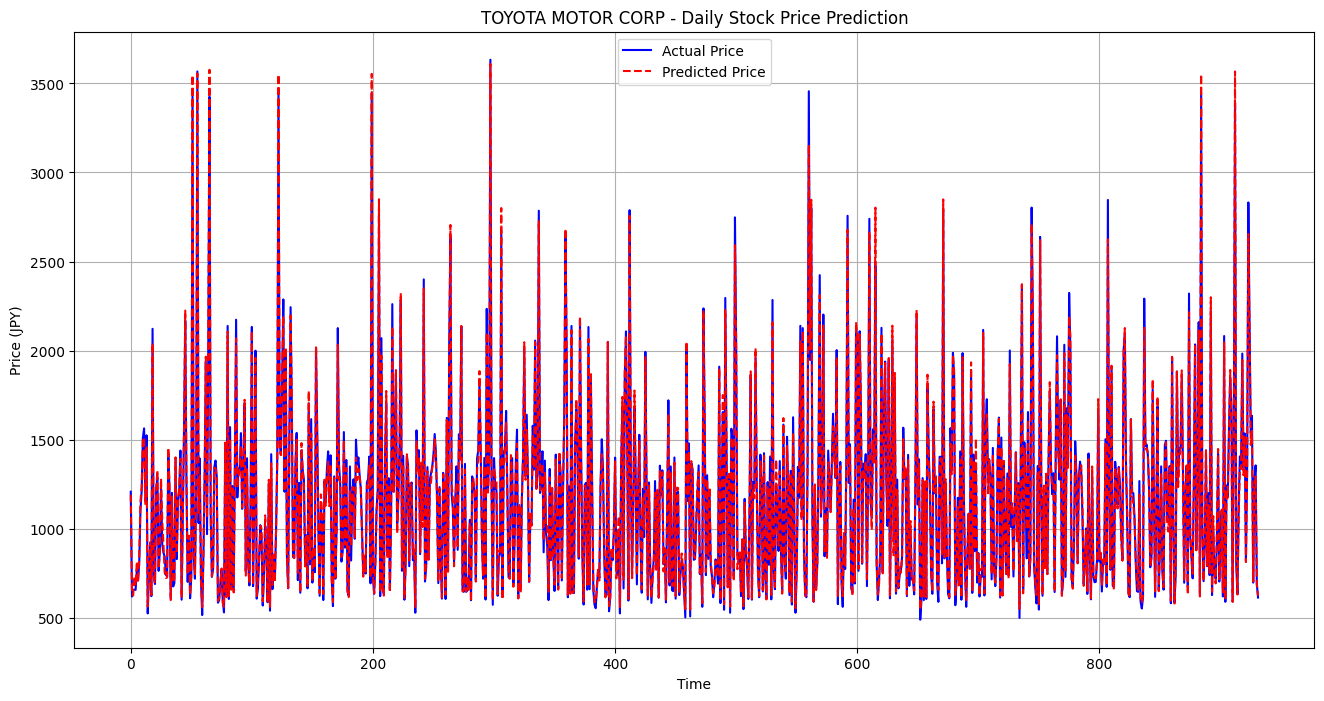

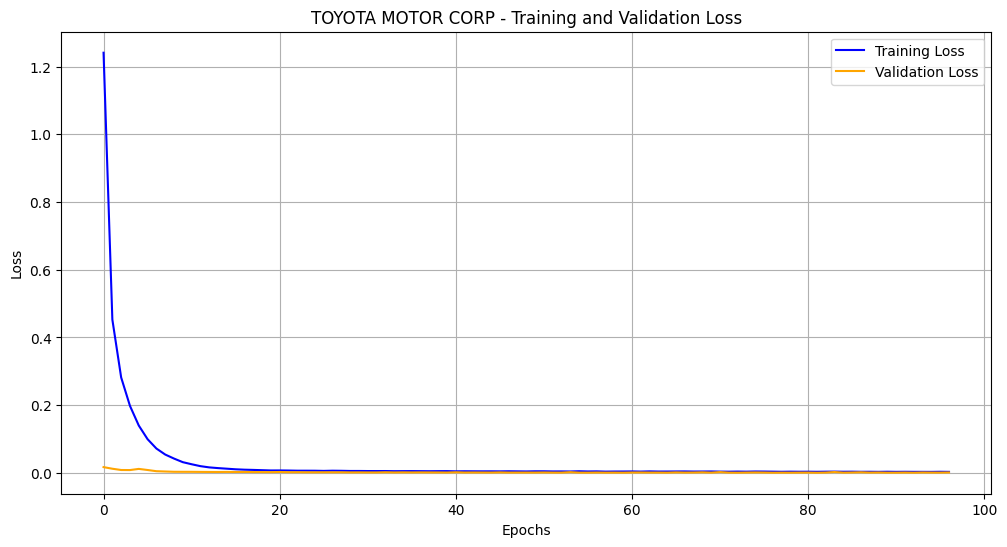

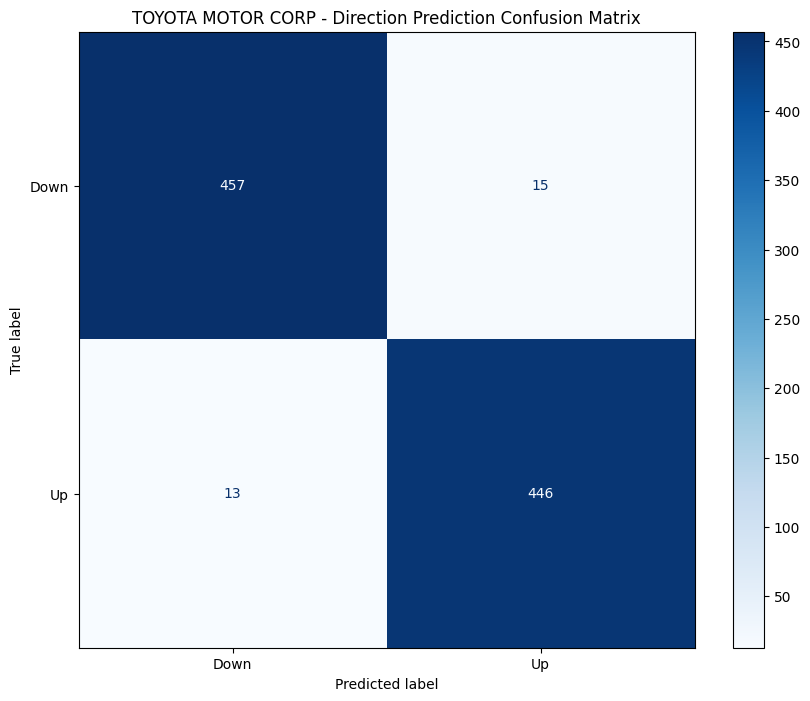


Performance Metrics for TOYOTA MOTOR CORP Direction Prediction:
Accuracy: 0.9699
Precision: 0.9675
Recall: 0.9717
F1 Score: 0.9696

Future Price Predictions for TOYOTA MOTOR CORP:
      Date  Predicted_Close
2024-05-24      3531.492850
2024-05-25      3551.296160
2024-05-26      3559.161523
2024-05-27      3564.443836
2024-05-28      3568.360927
2024-05-29      3571.176002
2024-05-30      3569.928817
2024-05-31      3556.112601
2024-06-01      3548.346244
2024-06-02      3545.102956
2024-06-03      3542.036623
2024-06-04      3538.735835
2024-06-05      3535.351834
2024-06-06      3531.968846
2024-06-07      3527.512590
2024-06-08      3522.376456
2024-06-09      3516.630701
2024-06-10      3510.707990
2024-06-11      3504.373466
2024-06-12      3497.430332
2024-06-13      3489.633402
2024-06-14      3481.607485
2024-06-15      3473.125212
2024-06-16      3464.287814
2024-06-17      3454.986772
2024-06-18      3445.640783
2024-06-19      3436.383878
2024-06-20      3426.157773
2024-06

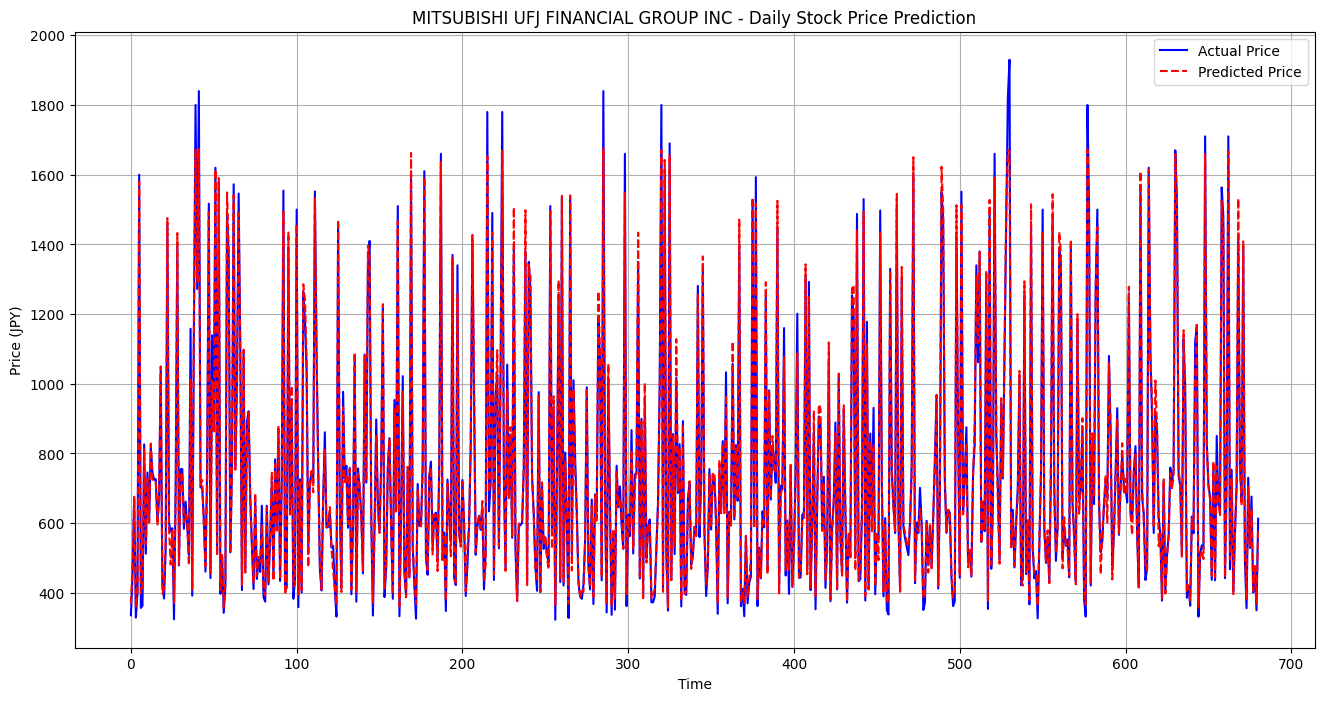

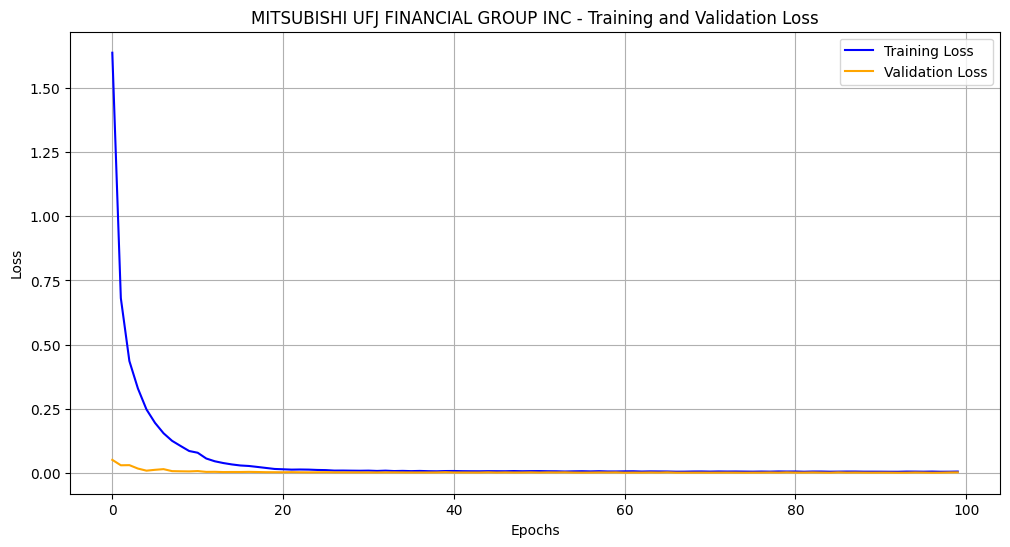

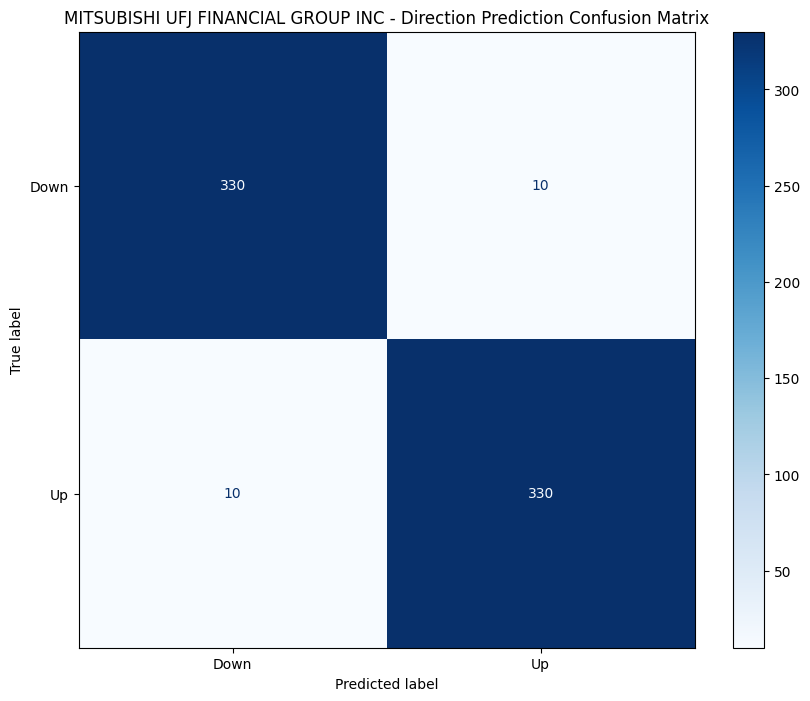


Performance Metrics for MITSUBISHI UFJ FINANCIAL GROUP INC Direction Prediction:
Accuracy: 0.9706
Precision: 0.9706
Recall: 0.9706
F1 Score: 0.9706

Future Price Predictions for MITSUBISHI UFJ FINANCIAL GROUP INC:
      Date  Predicted_Close
2024-05-24      1524.423987
2024-05-25      1534.274158
2024-05-26      1545.468106
2024-05-27      1555.679771
2024-05-28      1563.885800
2024-05-29      1569.337006
2024-05-30      1572.759447
2024-05-31      1574.120977
2024-06-01      1573.915903
2024-06-02      1572.466279
2024-06-03      1569.935722
2024-06-04      1567.169191
2024-06-05      1564.304681
2024-06-06      1560.944808
2024-06-07      1557.467091
2024-06-08      1554.042155
2024-06-09      1550.245743
2024-06-10      1546.108182
2024-06-11      1541.639931
2024-06-12      1537.074852
2024-06-13      1532.581938
2024-06-14      1528.316553
2024-06-15      1523.946568
2024-06-16      1520.093539
2024-06-17      1516.257399
2024-06-18      1512.734196
2024-06-19      1509.392555
2

In [20]:
stock_names = ['TOYOTA MOTOR CORP', 'MITSUBISHI UFJ FINANCIAL GROUP INC']
results = predict_multiple_stocks(df, stock_names, look_back=60, prediction_horizon='daily')
    
    # Visualize predictions
visualize_predictions(results, 'daily')


Processing KEYENCE CORP...


<ipython-input-7-839109985a8c>:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data = stock_data.fillna(method='ffill').fillna(method='bfill')
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in l

Epoch 1/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 32s 216ms/step - loss: 2.2768 - val_loss: 0.1898
Epoch 2/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 27s 213ms/step - loss: 0.7303 - val_loss: 0.0565
Epoch 3/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 27s 212ms/step - loss: 0.4747 - val_loss: 0.0102
Epoch 4/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 27s 212ms/step - loss: 0.3259 - val_loss: 0.0086
Epoch 5/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 27s 210ms/step - loss: 0.2601 - val_loss: 0.0098
Epoch 6/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 27s 210ms/step - loss: 0.1802 - val_loss: 0.0126
Epoch 7/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 27s 210ms/step - loss: 0.1398 - val_loss: 0.0042
Epoch 8/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 27s 210ms/step - loss: 0.1132 - val_loss: 0.0044
Epoch 9/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 27s 210ms/step - loss: 0.0796 - val_loss: 0.0053
Epoch 10/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 27s 210ms/step - loss: 0.0701 - val_loss: 0.0035
Epoch 11/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 27s 211ms/step - loss: 0.0490 - val_loss: 0.0018
Epoch 12

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━

<ipython-input-7-839109985a8c>:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data = stock_data.fillna(method='ffill').fillna(method='bfill')
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in l

Epoch 1/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 34s 215ms/step - loss: 1.4577 - val_loss: 0.0175
Epoch 2/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 211ms/step - loss: 0.3311 - val_loss: 0.0093
Epoch 3/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 210ms/step - loss: 0.2126 - val_loss: 0.0070
Epoch 4/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 210ms/step - loss: 0.1412 - val_loss: 0.0053
Epoch 5/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 209ms/step - loss: 0.0975 - val_loss: 0.0070
Epoch 6/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 209ms/step - loss: 0.0731 - val_loss: 0.0047
Epoch 7/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 209ms/step - loss: 0.0590 - val_loss: 0.0040
Epoch 8/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 208ms/step - loss: 0.0448 - val_loss: 0.0033
Epoch 9/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 209ms/step - loss: 0.0307 - val_loss: 0.0035
Epoch 10/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 209ms/step - loss: 0.0246 - val_loss: 0.0035
Epoch 11/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 211ms/step - loss: 0.0212 - val_loss: 0.0023
Epoch 12

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━

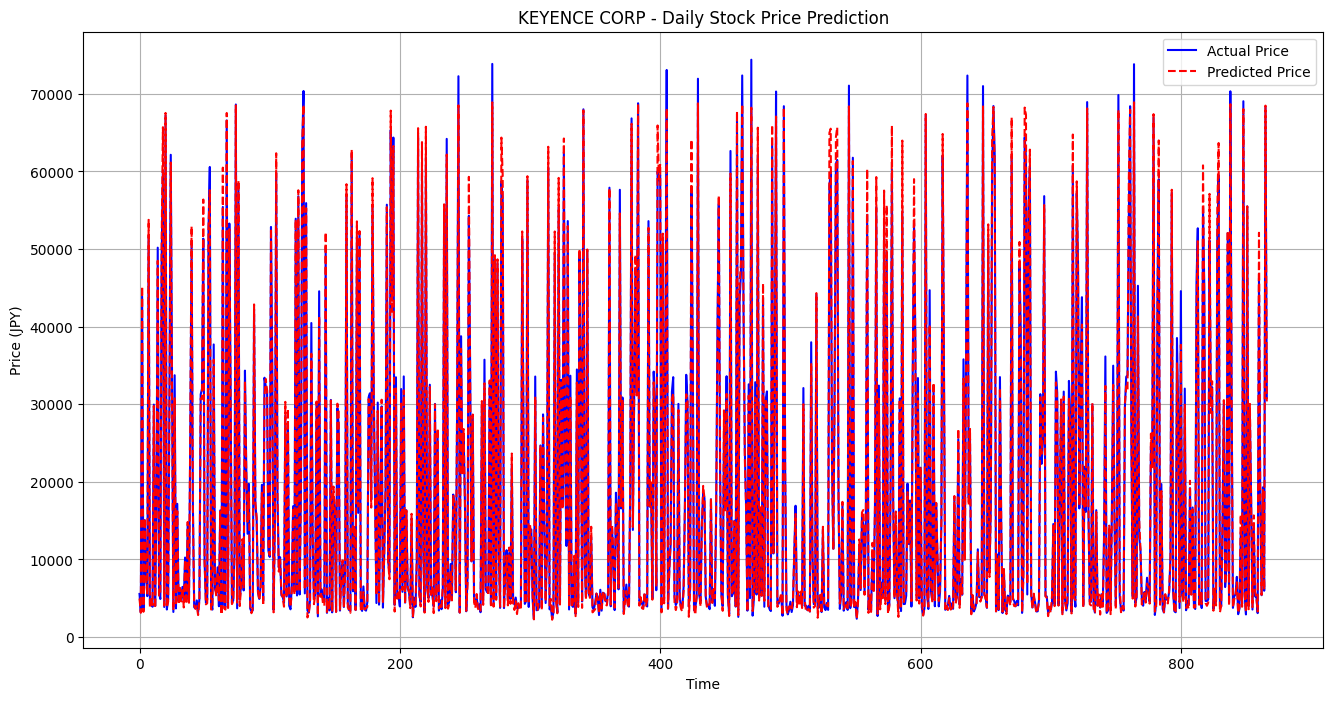

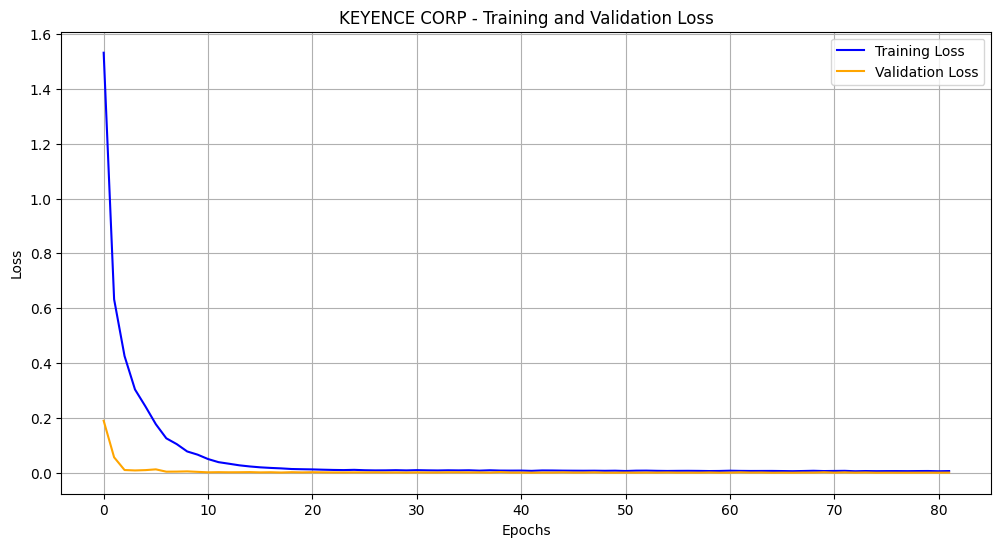

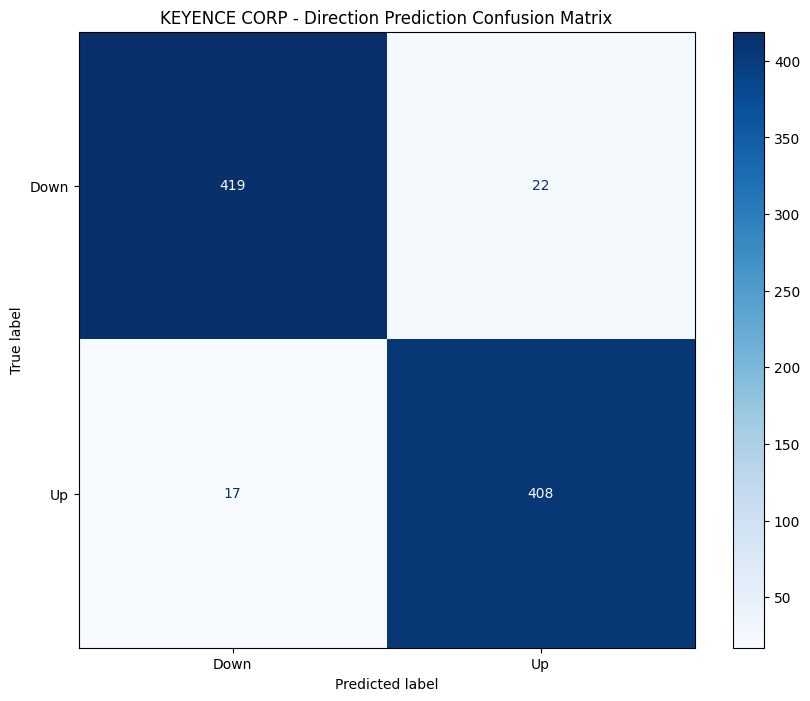


Performance Metrics for KEYENCE CORP Direction Prediction:
Accuracy: 0.9550
Precision: 0.9488
Recall: 0.9600
F1 Score: 0.9544

Future Price Predictions for KEYENCE CORP:
      Date  Predicted_Close
2024-05-24     68822.475922
2024-05-25     68716.901820
2024-05-26     68567.361588
2024-05-27     68418.331313
2024-05-28     68277.517485
2024-05-29     68147.896315
2024-05-30     68029.177654
2024-05-31     67920.561400
2024-06-01     67819.691203
2024-06-02     67727.556203
2024-06-03     67638.924953
2024-06-04     67555.208624
2024-06-05     67473.356273
2024-06-06     67392.879925
2024-06-07     67315.296258
2024-06-08     67238.125831
2024-06-09     67161.346664
2024-06-10     67083.530001
2024-06-11     67004.161488
2024-06-12     66925.566701
2024-06-13     66849.029324
2024-06-14     66773.692101
2024-06-15     66699.278076
2024-06-16     66626.512615
2024-06-17     66556.116692
2024-06-18     66487.391314
2024-06-19     66419.246231
2024-06-20     66355.418191
2024-06-21     66

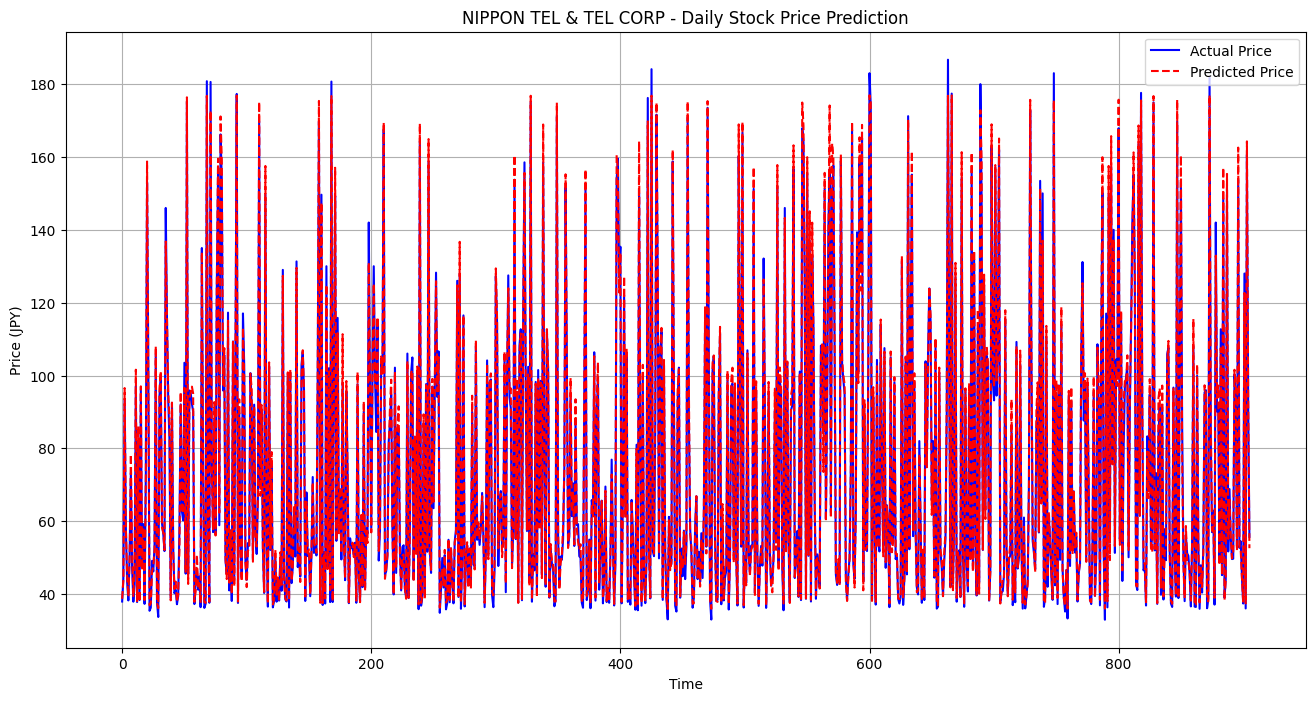

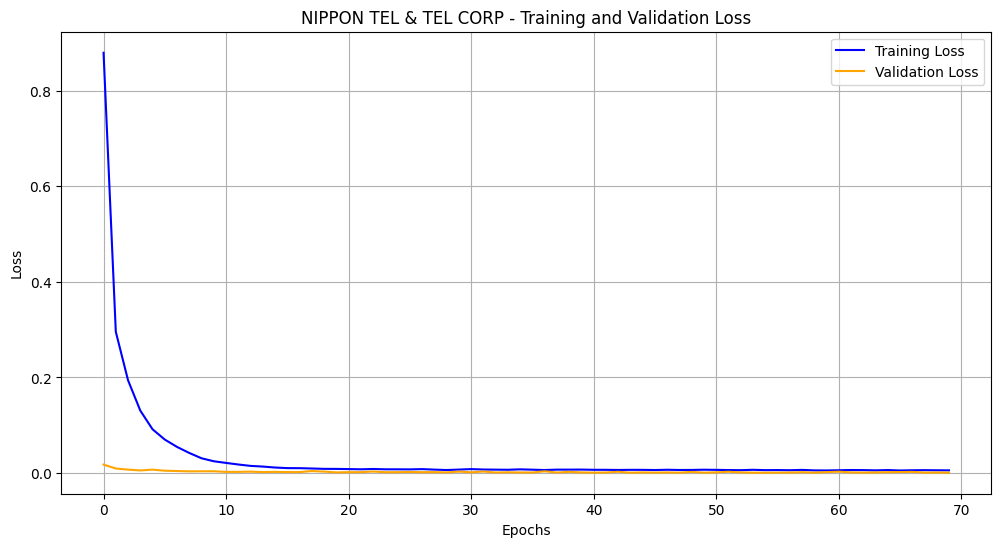

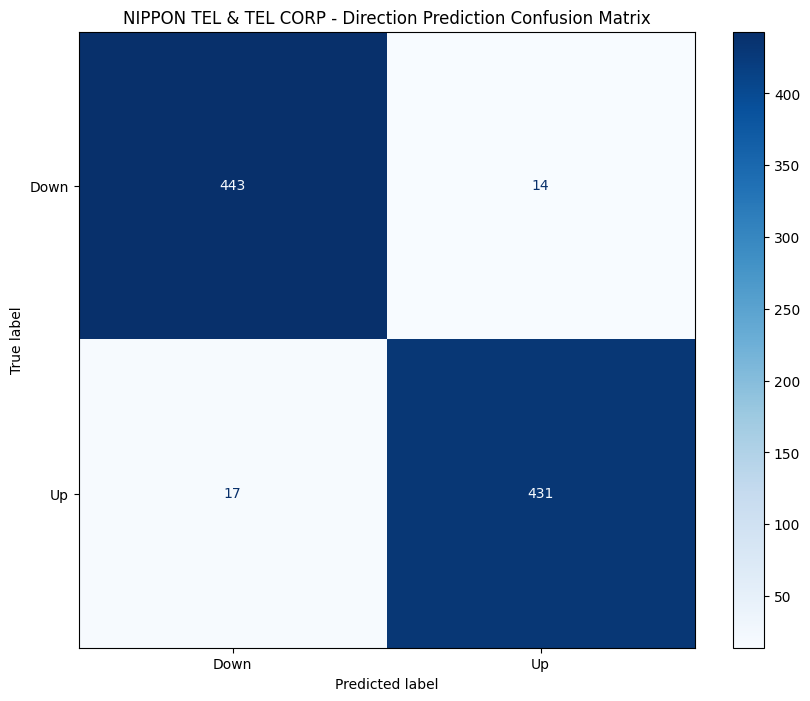


Performance Metrics for NIPPON TEL & TEL CORP Direction Prediction:
Accuracy: 0.9657
Precision: 0.9685
Recall: 0.9621
F1 Score: 0.9653

Future Price Predictions for NIPPON TEL & TEL CORP:
      Date  Predicted_Close
2024-05-24       168.222105
2024-05-25       168.407386
2024-05-26       168.617956
2024-05-27       168.744369
2024-05-28       168.709941
2024-05-29       168.568662
2024-05-30       168.333719
2024-05-31       168.035710
2024-06-01       167.731920
2024-06-02       167.416952
2024-06-03       167.064443
2024-06-04       166.674016
2024-06-05       166.243548
2024-06-06       165.794007
2024-06-07       165.336714
2024-06-08       164.809242
2024-06-09       164.243362
2024-06-10       163.662362
2024-06-11       163.053555
2024-06-12       162.502323
2024-06-13       161.924823
2024-06-14       161.377072
2024-06-15       160.790431
2024-06-16       160.138716
2024-06-17       159.479181
2024-06-18       158.806384
2024-06-19       158.139294
2024-06-20       157.439040

In [21]:
stock_names = ['KEYENCE CORP','NIPPON TEL & TEL CORP']
results = predict_multiple_stocks(df, stock_names, look_back=60, prediction_horizon='daily')
    
    # Visualize predictions
visualize_predictions(results, 'daily')


Processing MITSUBISHI HEAVY INDUSTRIES...


<ipython-input-7-839109985a8c>:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data = stock_data.fillna(method='ffill').fillna(method='bfill')
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in l

Epoch 1/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 33s 211ms/step - loss: 1.6613 - val_loss: 0.1523
Epoch 2/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 27s 206ms/step - loss: 0.4662 - val_loss: 0.0350
Epoch 3/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 27s 207ms/step - loss: 0.2573 - val_loss: 0.0180
Epoch 4/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 208ms/step - loss: 0.1726 - val_loss: 0.0109
Epoch 5/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 208ms/step - loss: 0.1145 - val_loss: 0.0076
Epoch 6/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 207ms/step - loss: 0.0937 - val_loss: 0.0052
Epoch 7/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 209ms/step - loss: 0.0584 - val_loss: 0.0059
Epoch 8/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 207ms/step - loss: 0.0472 - val_loss: 0.0037
Epoch 9/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 207ms/step - loss: 0.0308 - val_loss: 0.0033
Epoch 10/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 27s 204ms/step - loss: 0.0248 - val_loss: 0.0034
Epoch 11/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 27s 206ms/step - loss: 0.0188 - val_loss: 0.0028
Epoch 12

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━

<ipython-input-7-839109985a8c>:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data = stock_data.fillna(method='ffill').fillna(method='bfill')
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in l

Epoch 1/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 33s 213ms/step - loss: 0.7398 - val_loss: 0.0132
Epoch 2/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 208ms/step - loss: 0.1595 - val_loss: 0.0080
Epoch 3/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 209ms/step - loss: 0.0934 - val_loss: 0.0076
Epoch 4/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 210ms/step - loss: 0.0554 - val_loss: 0.0039
Epoch 5/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 210ms/step - loss: 0.0386 - val_loss: 0.0047
Epoch 6/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 208ms/step - loss: 0.0270 - val_loss: 0.0024
Epoch 7/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 208ms/step - loss: 0.0199 - val_loss: 0.0044
Epoch 8/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 209ms/step - loss: 0.0151 - val_loss: 0.0034
Epoch 9/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 209ms/step - loss: 0.0136 - val_loss: 0.0030
Epoch 10/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 210ms/step - loss: 0.0118 - val_loss: 0.0023
Epoch 11/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 209ms/step - loss: 0.0094 - val_loss: 0.0016
Epoch 12

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━

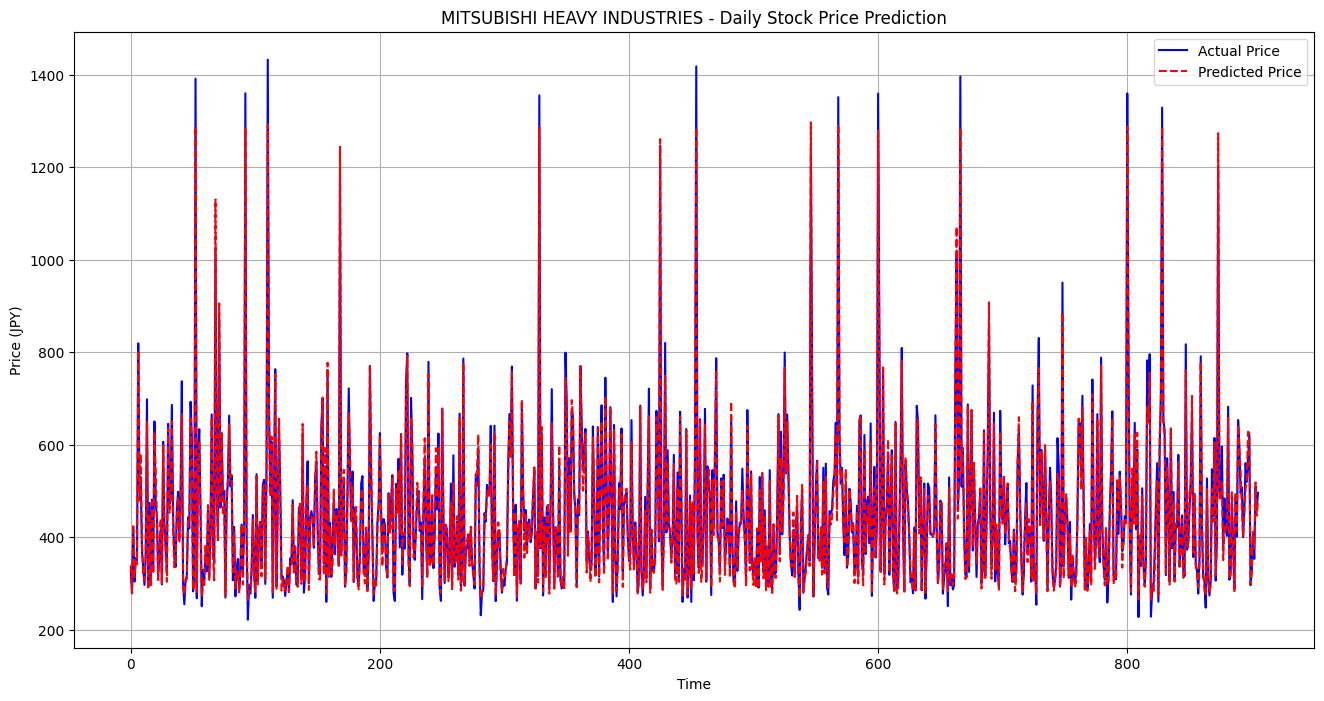

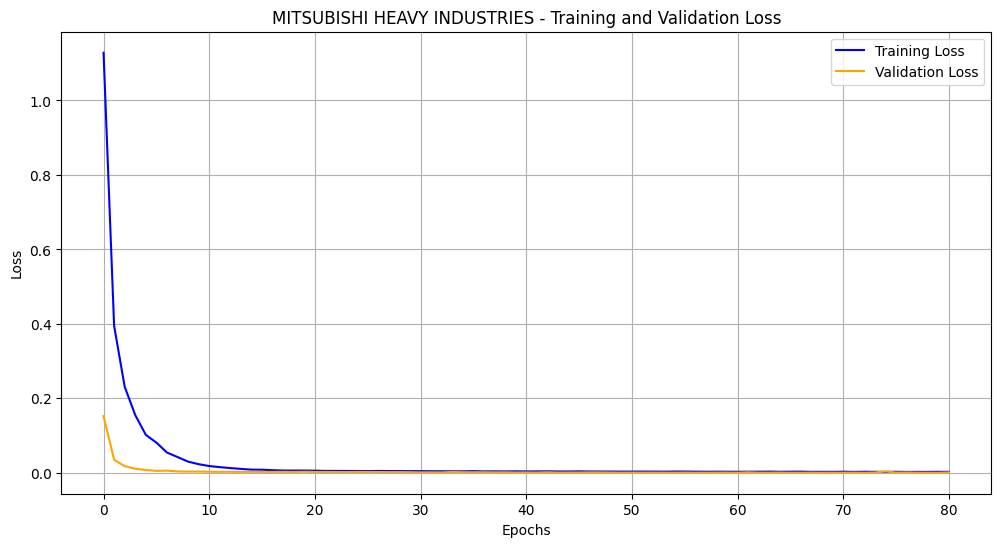

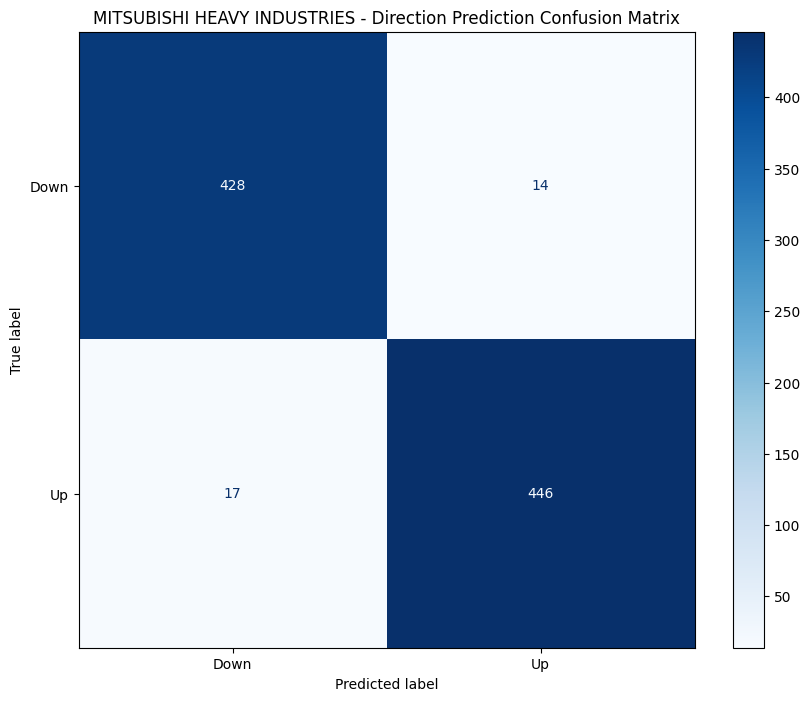


Performance Metrics for MITSUBISHI HEAVY INDUSTRIES Direction Prediction:
Accuracy: 0.9657
Precision: 0.9696
Recall: 0.9633
F1 Score: 0.9664

Future Price Predictions for MITSUBISHI HEAVY INDUSTRIES:
      Date  Predicted_Close
2024-05-24      1287.926969
2024-05-25      1288.214243
2024-05-26      1288.417952
2024-05-27      1288.545469
2024-05-28      1288.629613
2024-05-29      1288.699444
2024-05-30      1288.761034
2024-05-31      1288.810624
2024-06-01      1288.846912
2024-06-02      1288.870478
2024-06-03      1288.883057
2024-06-04      1288.885659
2024-06-05      1288.880743
2024-06-06      1288.870912
2024-06-07      1288.858768
2024-06-08      1288.846190
2024-06-09      1288.834479
2024-06-10      1288.823925
2024-06-11      1288.814961
2024-06-12      1288.807009
2024-06-13      1288.800069
2024-06-14      1288.793997
2024-06-15      1288.787780
2024-06-16      1288.781564
2024-06-17      1288.776214
2024-06-18      1288.769853
2024-06-19      1288.764793
2024-06-20     

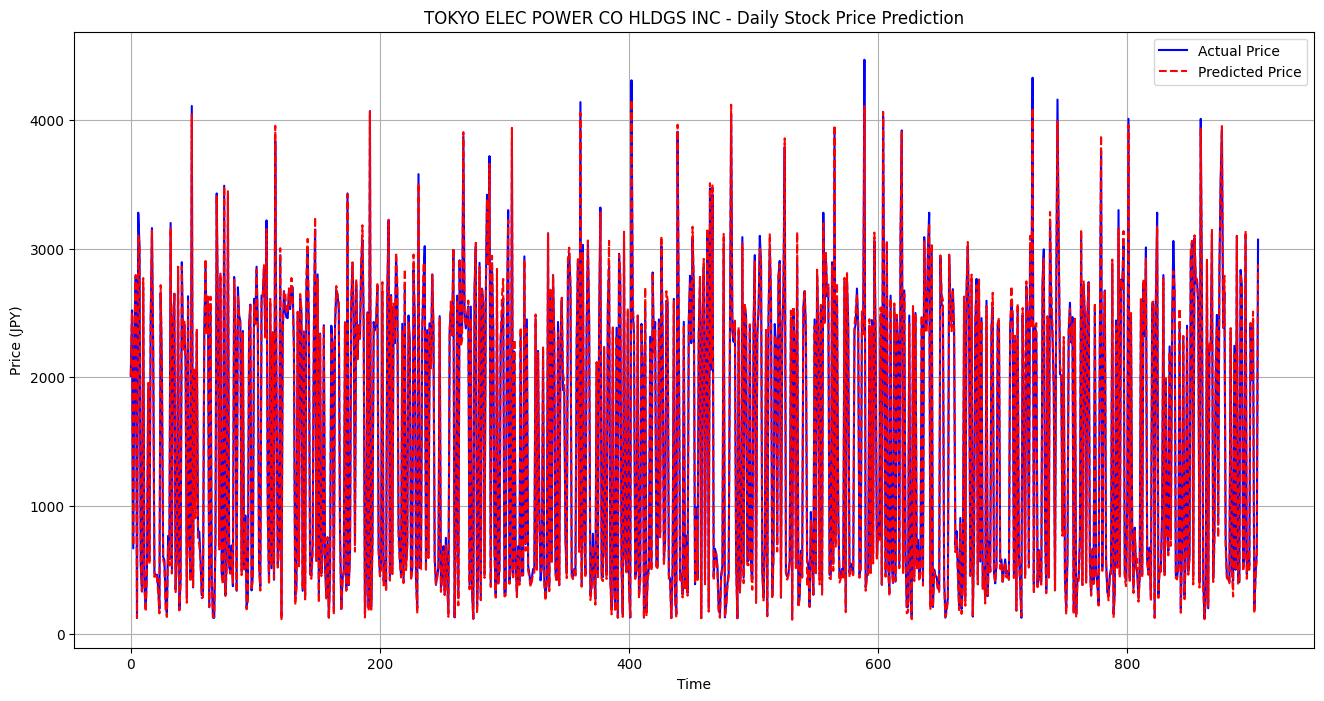

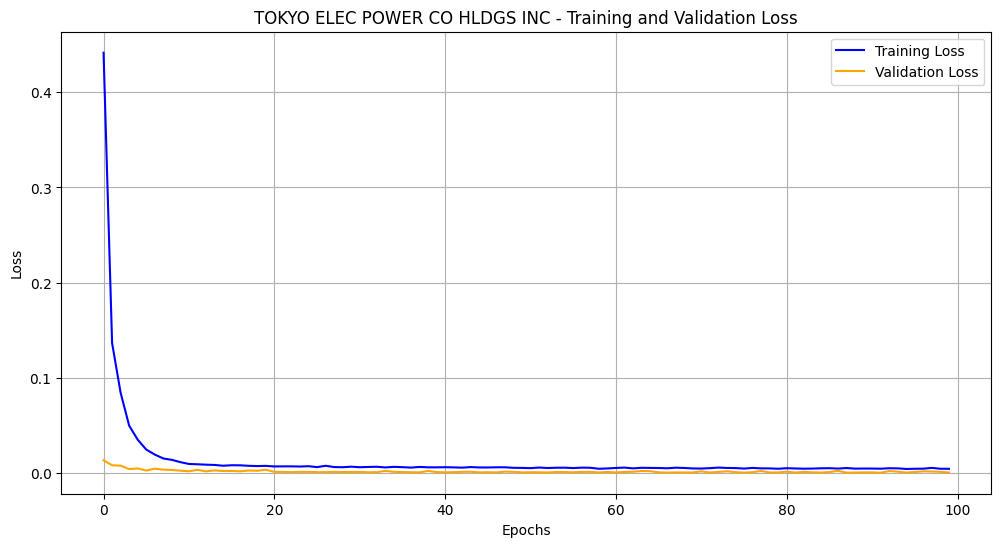

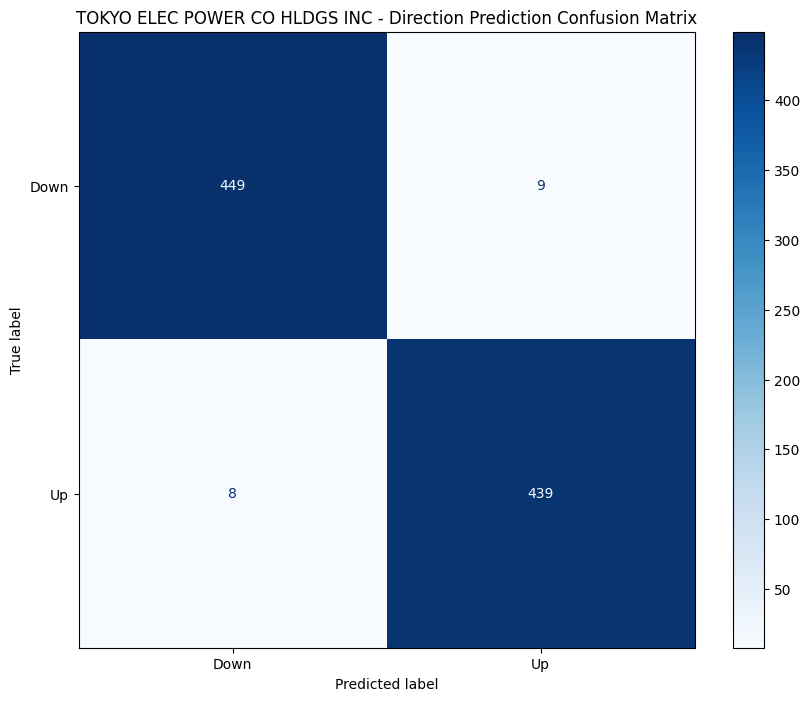


Performance Metrics for TOKYO ELEC POWER CO HLDGS INC Direction Prediction:
Accuracy: 0.9812
Precision: 0.9799
Recall: 0.9821
F1 Score: 0.9810

Future Price Predictions for TOKYO ELEC POWER CO HLDGS INC:
      Date  Predicted_Close
2024-05-24       881.655971
2024-05-25       838.623620
2024-05-26       762.112027
2024-05-27       676.576874
2024-05-28       587.778554
2024-05-29       522.834819
2024-05-30       480.533446
2024-05-31       432.498632
2024-06-01       382.043152
2024-06-02       335.357276
2024-06-03       296.468807
2024-06-04       265.878128
2024-06-05       242.283175
2024-06-06       224.018090
2024-06-07       209.601122
2024-06-08       197.951300
2024-06-09       188.406133
2024-06-10       180.193237
2024-06-11       172.875511
2024-06-12       166.200352
2024-06-13       159.924276
2024-06-14       153.858223
2024-06-15       147.944250
2024-06-16       142.139651
2024-06-17       136.517602
2024-06-18       131.190339
2024-06-19       126.204608
2024-06-20 

In [19]:
stock_names = ['MITSUBISHI HEAVY INDUSTRIES','TOKYO ELEC POWER CO HLDGS INC']
results = predict_multiple_stocks(df, stock_names, look_back=60, prediction_horizon='daily')
    
    # Visualize predictions
visualize_predictions(results, 'daily')


Processing MITSUI FUDOSAN...


<ipython-input-7-839109985a8c>:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data = stock_data.fillna(method='ffill').fillna(method='bfill')
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in l

Epoch 1/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 34s 213ms/step - loss: 1.4146 - val_loss: 0.0413
Epoch 2/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 208ms/step - loss: 0.3658 - val_loss: 0.0127
Epoch 3/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 208ms/step - loss: 0.2142 - val_loss: 0.0097
Epoch 4/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 209ms/step - loss: 0.1415 - val_loss: 0.0074
Epoch 5/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 210ms/step - loss: 0.0935 - val_loss: 0.0046
Epoch 6/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 207ms/step - loss: 0.0769 - val_loss: 0.0125
Epoch 7/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 208ms/step - loss: 0.0509 - val_loss: 0.0055
Epoch 8/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 207ms/step - loss: 0.0380 - val_loss: 0.0054
Epoch 9/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 208ms/step - loss: 0.0327 - val_loss: 0.0036
Epoch 10/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 208ms/step - loss: 0.0252 - val_loss: 0.0031
Epoch 11/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 28s 208ms/step - loss: 0.0202 - val_loss: 0.0032
Epoch 12

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━

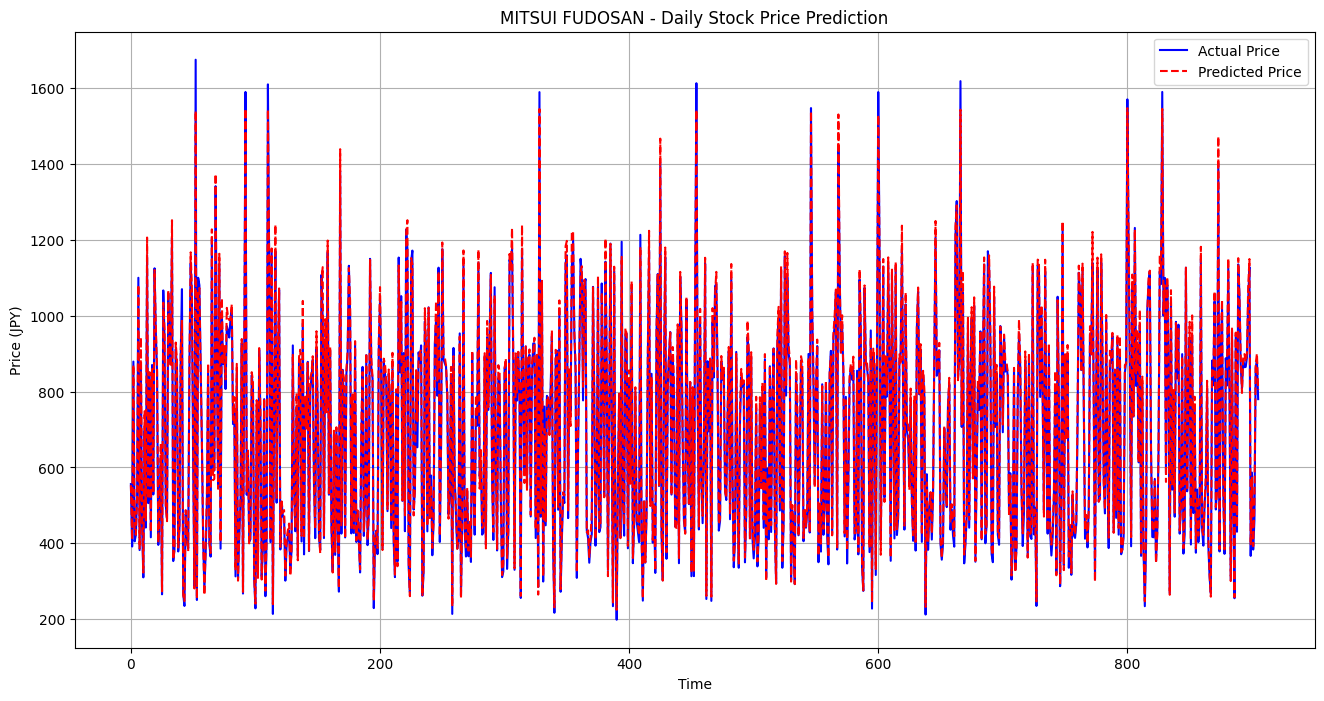

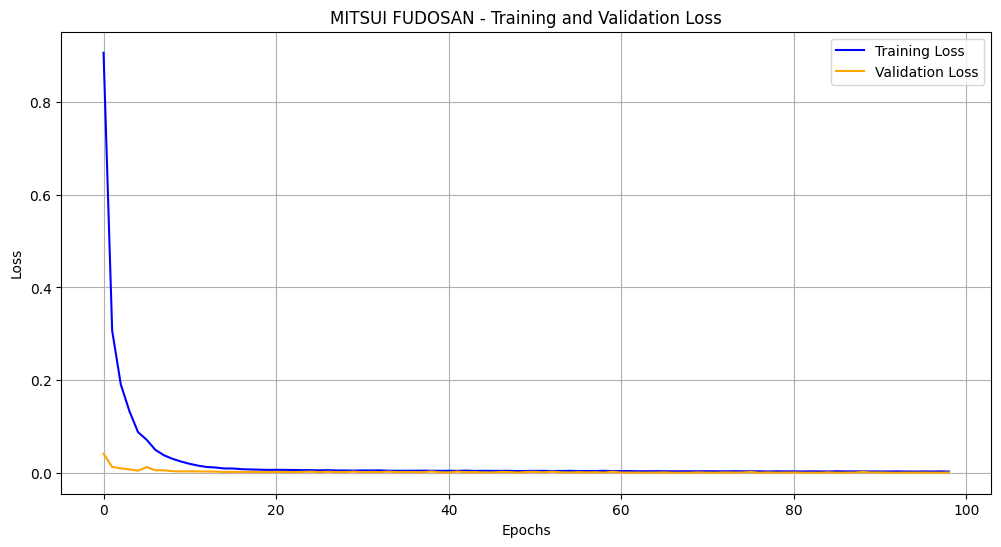

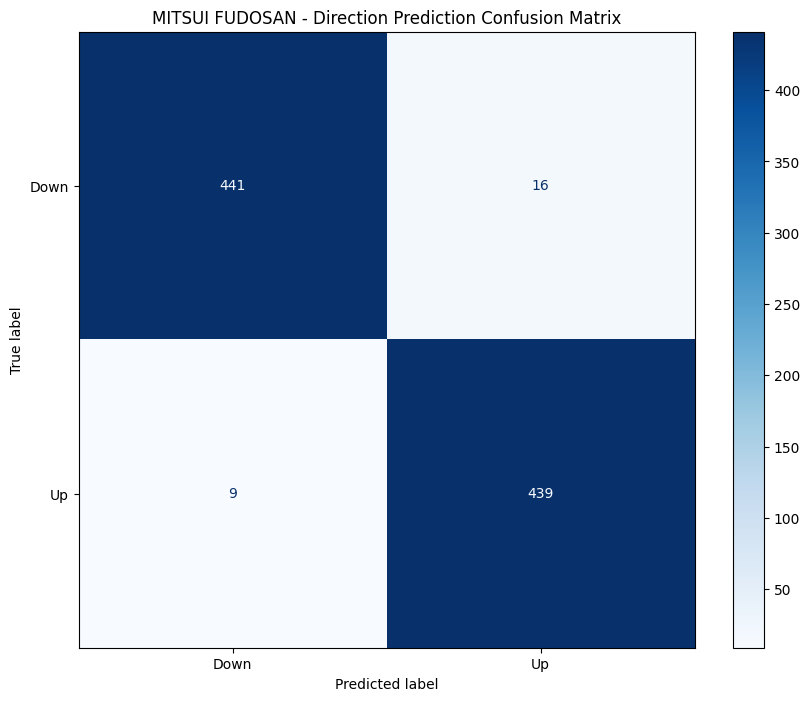


Performance Metrics for MITSUI FUDOSAN Direction Prediction:
Accuracy: 0.9724
Precision: 0.9648
Recall: 0.9799
F1 Score: 0.9723

Future Price Predictions for MITSUI FUDOSAN:
      Date  Predicted_Close
2024-05-24      1510.600312
2024-05-25      1540.232113
2024-05-26      1549.133535
2024-05-27      1552.334720
2024-05-28      1553.620879
2024-05-29      1554.199077
2024-05-30      1554.475729
2024-05-31      1554.608671
2024-06-01      1554.666755
2024-06-02      1554.683351
2024-06-03      1554.673994
2024-06-04      1554.653867
2024-06-05      1554.628444
2024-06-06      1554.602139
2024-06-07      1554.577951
2024-06-08      1554.557295
2024-06-09      1554.538581
2024-06-10      1554.520043
2024-06-11      1554.504154
2024-06-12      1554.490560
2024-06-13      1554.482791
2024-06-14      1554.475376
2024-06-15      1554.468314
2024-06-16      1554.462312
2024-06-17      1554.456662
2024-06-18      1554.453661
2024-06-19      1554.449071
2024-06-20      1554.446952
2024-06-21   

In [20]:
stock_names = ['MITSUI FUDOSAN']
results = predict_multiple_stocks(df, stock_names, look_back=60, prediction_horizon='daily')
    
    # Visualize predictions
visualize_predictions(results, 'daily')